# Modeling age-related changes in electrical activity in CA1 pyramidal cells

#### Erin C. McKiernan<sup>1</sup>, Marco A. Herrera-Valdez<sup>2</sup>, and Diano F. Marrone<sup>3</sup>

##### <sup>1</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México
##### <sup>2</sup> Departamento de Matemáticas, Facultad de Ciencias, Universidad Nacional Autónoma de México
##### <sup>3</sup> Department of Psychology, Wilfrid Laurier University

# Overview

We are interested in modeling age-related changes in ion channel expression and excitability in CA1 pyramidal cells (PCs). However, before we can model aging, we have to create a representative young CA1 PC. PCs in the CA1 region of the hippocampus show a diversity of firing patterns, including repetitive slow firing with frequency adaptation, conditional bursting (bursting in response only to a stimulus), and endogenous bursting in the absence of stimulation. We can build a 3-dimensional model, based on electrophysiological data, to determine under what conditions these different firing patterns can be reproduced. We will vary primarily the density of ion channels in the model membrane and specific biophysical properties of the channels, such as their rate of activation. In this way, we can understand the different balances of currents that produce these firing patterns and then compare the firing in young and aged PCs. We assume that the passive membrane properties of young and aged cells are identical and that these cells primarily differ in their calcium channel density, as shown in the experimental literature.

# CA1 pyramidal cell model: defining the necessary functions

First, we import the Python modules needed for plotting figures. We include several commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [41]:
# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting modules and settings
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker # rescaling units in figures
from mpl_toolkits.axes_grid1.inset_locator import mark_inset # figure insets
from mpl_toolkits.axes_grid.inset_locator import inset_axes # figure insets

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 20 # fontsize for figure titles
plt.rcParams['font.size'] = 16 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.6 # line width for plotting

Next, we import additional modules for scientific computing, both numeric and symbolic.

In [42]:
# import scientific computing modules
import numpy as np 
import pyprocess as sp
import scipy as sc 
from scipy import integrate
import sympy as sy
import sys
import time
from cycler import cycler

Now, we import parameters for different ion channels from our Membrane Library. If parameters are not specifically changed before running simulations, the program will use those in the Membrane Library as default. These parameters can be changed at any time to see their effects on PC electrical activity.

In [43]:
# import Membrane Library
from membraneLibrary import *

Next, we define important functions, such as those used to calculate the Boltzmann potential, Nernst potentials for each ion, and perform normalization of the amplitudes and voltages.

In [44]:
# calculate Boltzmann or thermal potential at specified temp
def vBoltzmann(tempCelsius=22.0):
    return kBoltzmann*(zeroT+tempCelsius)/eCharge

# calculate Nernst potential for a given ion
def vNernst(cIn=140.0, cOut=5.0, val=1.0, tempCelsius=22.0):
    vT= kBoltzmann*(zeroT+tempCelsius)/eCharge
    vN= vT * sc.log(cOut/cIn) / val
    return vN

# calculate Boltzmann and Nernst potentials for ions 
def calcReversalPotentials(parDict):
    parDict['vT'] = vBoltzmann(parDict['tempCelsius'])
    parDict['vCl']=vNernst(cIn=parDict['inCl'], cOut=parDict['outCl'], val=-1.0,\
                           tempCelsius=parDict['tempCelsius'])
    parDict['vCa']=vNernst(cIn=parDict['inCa'], cOut=parDict['outCa'], val=2.0, \
                           tempCelsius=parDict['tempCelsius'])
    parDict['vNa']=vNernst(cIn=parDict['inNa'], cOut=parDict['outNa'], val=1.0, \
                           tempCelsius=parDict['tempCelsius'])
    parDict['vKa']=vNernst(cIn=parDict['inKa'], cOut=parDict['outKa'], val=1.0, \
                           tempCelsius=parDict['tempCelsius'])
    parDict['vATP']= -450.0; 
    parDict['vNaKa'] = 3*parDict['vNa'] - 2*parDict['vKa'] + parDict['vATP']
    return parDict

# normalize voltages by Boltzmann potential (vT)
def normalizeVolts(parDict):
    nDict={}
    for k,i in parDict.items():
        if ((k.find('v')==0)|(k.find('vHalfP')==0)):
            nn=k.find('overvT')
            if nn>0:
                nDict[k]=parDict[k[:nn]]/parDict['vT']
            else:
                nDict[k+'overvT']=parDict[k]/parDict['vT']

    parDict.update(nDict)
    return parDict

# normalize amplitudes by capacitance (Cm) and Boltzmann potential (vT)
def normalizeAmps(parDict):
    nDict={}
    vC= parDict['Cm'] * parDict['vT']
    nDict['vTCm']=vC
    for k,i in parDict.items():
        nn=k.find('overvTCm')
        if nn>0:
           nDict[k]=parDict[k[:nn]]/vC
        elif k.find('a_')==0:
           nDict[k+'overvTCm']=parDict[k]/vC
           
    parDict.update(nDict)
    return parDict

We also define exponential functions that will be used to calculate ion channel gating and steady states. 

In [45]:
# define exponential functions
def nExpSub(y, s=0.5):
    ee = sc.exp(y)
    return (ee**s) * (1 - 1/ee)

def nExpSum(y, s=0.5):
    ee = sc.exp(y)
    return (ee**s) * (1 + 1/ee)

def nExpSigmoid(y):
    ee = sc.exp(y)
    return ee/(1+ee)

Next, we define the right-hand side. The model has three variables: the change in voltage (<i>v</i>), potassium channel activation (<i>w</i>), and intracellular calcium concentration (<i>c</i>). The currents include a transient sodium current (<i>NaT</i>), a delayed rectifier potassium current (<i>Kd</i>), a L-type calcium current (<i>Cav1.2</i> or <i>Cav1.3</i>, or a balance of the two channels), a calcium-dependent potassium current (<i>SK</i>), and a sodium-potassium pump (<i>NaK</i>).

In [46]:
# define the right-hand side of the model
def NaTKDSKCaL(U,t,p):
    y,w,c=U
    p['vCa']=vNernst(cIn=c, cOut=p['outCa'], val=2.0, tempCelsius=p['tempCelsius'])
    p['vCaovervT']=p['vCa']/p['vT']
    # gating
    yyKaD = p['gainP_KaD']*(y-p['vHalfP_KaDovervT'])
    wInf = nExpSigmoid(yyKaD)
    wRate = p['rateP_KaD'] * nExpSum(yyKaD,s=p['symmP_KaD'])
    m12Inf = nExpSigmoid(p['gainP_Ca12']*(y-p['vHalfP_Ca12overvT']))
    m13Inf = nExpSigmoid(p['gainP_Ca13']*(y-p['vHalfP_Ca13overvT']))
    mInf = nExpSigmoid(p['gainP_NaT']*(y-p['vHalfP_NaTovervT']))
    cDiff=p['gainP_KaSK']*(c-p['cHalfP_KaSK'])
    skInf=  nExpSigmoid(cDiff)
    # currents
    jNa = p['a_NaTovervTCm'] * mInf * (1-w) * nExpSub(y- p['vNaovervT'], s=p['symm_NaT'])
    aCaL =p['a_Ca12overvTCm'] * m12Inf + p['a_Ca13overvTCm'] * m13Inf 
    jCaL = aCaL * (c**(1-p['symm_Ca13'])) * nExpSub(2*(y- p['vCaovervT']), s=p['symm_Ca13'])
    aK = (p['a_KaSKovervTCm'] * skInf + p['a_KaDovervTCm'] * w )
    jK = aK * nExpSub(y- p['vKaovervT'], s=p['symm_KaD'])
    jNaKa = p['a_NaKaovervTCm'] * nExpSub(y- p['vNaKaovervT'], s=p['symm_NaKa'])
    # dynamics
    dy = p['jStim'](t) - jNa - jK - jNaKa - jCaL 
    dw = w * (wInf-w)* wRate
    dc= p['rc_Ca'] * (p['cMin_Ca']-c) - p['kc_Ca']* (jCaL*p['vTCm'])
    if p['verboseSimulation']:
        print(t,c, p['a_NaT'], p['a_KaD'], p['a_CaL'], p['vCa'])
    return dy,dw,dc

The following function runs the model and calculates the <i>v</i> (or the normalized version, <i>y</i>), <i>w</i>, and <i>c</i> orbits to simulate the change in voltage, activation of potassium channels, and the intracellular calcium over time, respectively. 

In [7]:
# simulate the firing activity of the model CA1 PC
def simulate3DNeuron(p,graph=1,plotStim=1,plotLFP=0):
    orbit= sc.integrate.odeint(func=p['rhs'], y0=p['ic'], t=p['sampTimes'], args=(p,),\
                               rtol=p['rTol'],atol=p['aTol']).transpose()
    y=orbit[0]
    v=orbit[0]*p['vT']
    w=orbit[1]
    c=orbit[2]
    dvdt= sc.zeros(len(v))
    dvdt[1:] = (v[1:]-v[:-1])/p['timeStep']
    p['vCa']=vNernst(cIn=c, cOut=p['outCa'], val=2.0, tempCelsius=p['tempCelsius'])
    p['vCaovervT']=p['vCa']/p['vT']
    cDiff=p['gainP_KaSK']*(c-p['cHalfP_KaSK'])
    skInf=  nExpSigmoid(cDiff)
    mInf = nExpSigmoid(p['gainP_NaT']*(y-p['vHalfP_NaTovervT']))
    m12Inf = nExpSigmoid(p['gainP_Ca12']*(y-p['vHalfP_Ca12overvT']))
    m13Inf = nExpSigmoid(p['gainP_Ca13']*(y-p['vHalfP_Ca13overvT']))
    iCa12 = (c**(1-p['symm_Ca12'])) * p['a_Ca12'] * m12Inf * nExpSub(2*(y- p['vCaovervT']),\
                                                                     s=p['symm_Ca12'])/1000.0
    iKaD = p['a_KaD'] * w * nExpSub(y- p['vKaovervT'], s=p['symm_KaD'])/1000.0
    iNaT = p['a_NaT'] * mInf * (1-w) * nExpSub(y- p['vNaovervT'], s=p['symm_NaT'])/1000.0
    iKaSK = p['a_KaSK'] * skInf * nExpSub(y- p['vKaovervT'], s=p['symm_KaD'])/1000.0
    iNaKa = p['a_NaKa'] * nExpSub(y- p['vNaKaovervT'], s=p['symm_NaKa'])/1000.0
    iStim = (p['jStim'](p['sampTimes']))*p['vTCm']
    xx={'v':v,'w':w,'y':y,'dv/dt':dvdt,'c':c,'vCa':p['vCa'],'mInf':mInf,'skInf':skInf,'iCa12':iCa12,'iKaD':iKaD,\
        'iNaKa':iNaKa,'iNaT':iNaT,'iKaSK':iKaSK,'iStim':iStim,'sampTimes':p['sampTimes'],\
        'aCaLnorm':p['a_Ca12overvTCm']}
    if graph:
        ax1=list()
        fig1=plt.figure(figsize=(15,5))
        plt.ioff()
        r=1; c=1
        for n in sc.arange(r*c):
            ax1.append(fig1.add_subplot(r,c,n+1))

        ax1[0].plot(xx['sampTimes'],xx['v'])
        ax1[0].set_xlabel('Time (ms)')
        ax1[0].set_ylabel('V (mV)')
        ax1[0].set_ylim(-90,65)
        plt.ion(); plt.draw()
        plt.show()
    return xx

Now, we define the current injection function that will allow us to stimulate the model CA PC to test its responses. We can set the start and stop times so that the pulse turns on and off nearly instantaneously, creating a square pulse. Or, we can vary the start and stop times of the up and down phases to create ramp pulses with varying slopes and plateaus. 

In [8]:
# define current injection function
def UpTopDn(t,upStart=200.0,upStop=400, dnStart=600.0,dnStop=800.0,rampAmp=1.0):
    slope_up = rampAmp/(upStop-upStart)
    int_up = -slope_up*upStart
    slope_dn = -rampAmp/(dnStop-dnStart)
    int_dn= rampAmp-slope_dn*dnStart
    c1=sc.int16((upStart<t)&(t<=upStop))
    c2=sc.int16((upStop<t)&(t<=dnStart))
    c3=sc.int16((t>dnStart)&(t<=dnStop))
    y=c1*(slope_up*t +int_up)+ c2*rampAmp+ c3*(slope_dn*t +int_dn)
    return y

Next, we create a dictionary with the relevant parameters. The <i>a</i>'s below represent the maximum amplitudes of the currents, which can be thought of as an indicator of the number of functional channels in the membrane. For example, <i>a_NaT</i> represents the sodium channel density. <i>KaD</i> stands for delayed rectifier potassium channel; <i>KaSK</i> for calcium-dependent potassium channel; and <i>NaKa</i> for sodium-potassium pump. The Nernst potentials, as determined by internal and external ion concentrations (e.g. <i>outNa</i>, <i>inNa</i>), remain fixed, with the exception of the Nernst potential for calcium, which varies with the changes in concentration. Other biophysical channel properties, such as half-activation voltages (e.g. <i>vHalfP_NaT</i>) and gating charges (e.g. <i>gainP_NaT</i>), also remain fixed. The only channel properties that will be varied are the amplitudes (i.e. the number of functional channels in the membrane) and the kinetics (e.g. <i>rateP_KaD</i>).

In [9]:
# gather baseline parameters from biophysMembrane; add channel suffixes to create keys for the parameters
def parameters3D(includeSyn=0):
    p = biophysMembrane.copy()
    p.update(numerics)
    p.update(addSuffix(biophysLFP,suff='_LFP'))
    p.update(addSuffix(biophysCalcium,suff='_Ca'))
    p.update(addSuffix(biophysKaD,suff='_KaD'))
    p.update(addSuffix(biophysKaSK,suff='_KaSK'))
    p.update(addSuffix(biophysCa13,suff='_Ca13'))
    p.update(addSuffix(biophysCa12,suff='_Ca12'))
    p.update(addSuffix(biophysNaKa,suff='_NaKa'))
    p.update(addSuffix(biophysNaT,suff='_NaT'))
    if includeSyn:
        p.update(addSuffix(biophysGluAMPA,suff='_GluA'))
        p.update(addSuffix(biophysGABAA,suff='_GABAA'))
    p= calcReversalPotentials(p)
    for k in p.keys():
        if k.find('Name')>-1:
            del p[k]
    return p

def addSuffix(p,suff='',removeOriginal=1):
    pa= p.copy()
    for key, val in p.items():
        pa[key+suff]=val
        if removeOriginal:
            pa.pop(key)
    return pa

In [10]:
# create a dictionary with the desired parameters
def pars(timeMax=100.0,timeStep=3e-4, includeSyn=0):
    p=parameters3D(includeSyn)
    p['a_NaT']=1e3
    p['a_KaD']=1.5e4
    p['a_KaSK']=8e2   
    p['a_NaKa']=0.01*p['a_NaT']
    p['a_Ca13']=0.0
    p['a_Ca12']=3e3
    p['inCa']=0.0001
    p['inCl']=10.0
    p['inKa']=140.0
    p['inNa']=10.0
    p['outCa']=2.5
    p['outCl']=150.0
    p['outKa']=5.0
    p['outNa']=150.0
    p['rateP_KaD']=1.0
    p['symmP_Ca12']= 0.5,
    p['symmP_Ca13']= 0.5,
    p['symmP_KaD']= 0.3,
    p['symmP_KaSK']= 0.3,
    p['symmP_NaT']= 0.5,
    p['vHalfP_NaT']=-19.0
    p['vHalfP_Ca12']=3.0
    p['vHalfP_Ca13']=-20.0
    p['vHalfP_KaD']=-1.0
    p['gainP_NaT']=4.0
    p['gainP_Ca12']=4.0
    p['gainP_KaD']=4.0
    p['gainP_KaSK']=5e3
    p['cHalfP_KaSK']=5.6e-4
    p['cMin']=1e-4
    p['rc_Ca']=7e-4
    p['kc_Ca']=8e-9
    p['Cm']=20.0
    p['ic']= [-2.2, 0.005, 1e-4]
    p['rTol']=1e-6
    p['aTol']=1e-9
    p['upStart']=200.0
    p['upStop']=200.001
    p['dnStart']=1000.0
    p['dnStop']=1000.001
    p['rampAmp']=100
    p['rhs']=NaTKDSKCaL
    p['tempCelsius']=37.0
    p['timeMax']=timeMax
    p['timeStep']=timeStep
    p['sampTimes']=sc.arange(0,p['timeMax'],p['timeStep'])
    p=calcReversalPotentials(p)
    p=normalizeVolts(p)
    p=normalizeAmps(p)
    p['verboseSimulation']=1
    return p

# Simulating CA1 PC electrical activity

## Repetitive slow firing with adaptation

Many CA1 pyramidal cells respond to square-pulse current injection by firing several early spikes followed by marked adaptation, which slows the frequency of firing. In aged animals, this adaptation is more pronounced than in young animals, leading to a shorter initial period of fast spiking, followed by fewer spikes or even complete cessation of activity. The increased adaptation seen in aged PCs is functionally relevant, as it is correlated with learning impairment.

Our first challenge was to tune the model to produce early-onset firing with spike frequency adaptation. Previous work from two of the current authors (ECM and MAHV) using a similar model has shown that early-onset firing (i.e. without a significant delay to first spike) is typically produced when the system transitions from rest to repetitive spiking through a fold limit cycle (FLC) bifurcation. The system is most likely to transition through an FLC bifurcation when the ratio of K<sup>+</sup> to Na<sup>+</sup> channels is high. For these simulations, the number of K<sup>+</sup> channels was set to 15 times the number of Na<sup>+</sup> channels, as supported by data from previous studies. The activation of delayed rectifier K<sup>+</sup> channels is fast at 1 ms, and both Ca<sup>2+</sup> current-to-concentration conversion and buffering are relatively weak. This combination of parameters successfully reproduces both the initial frequency of firing and rate of adaptation seen in some mammalian CA1 PCs in response to a similar-amplitude current pulse. Compare this response to CA1 PC recordings from Moyer et al. (1992), for example.

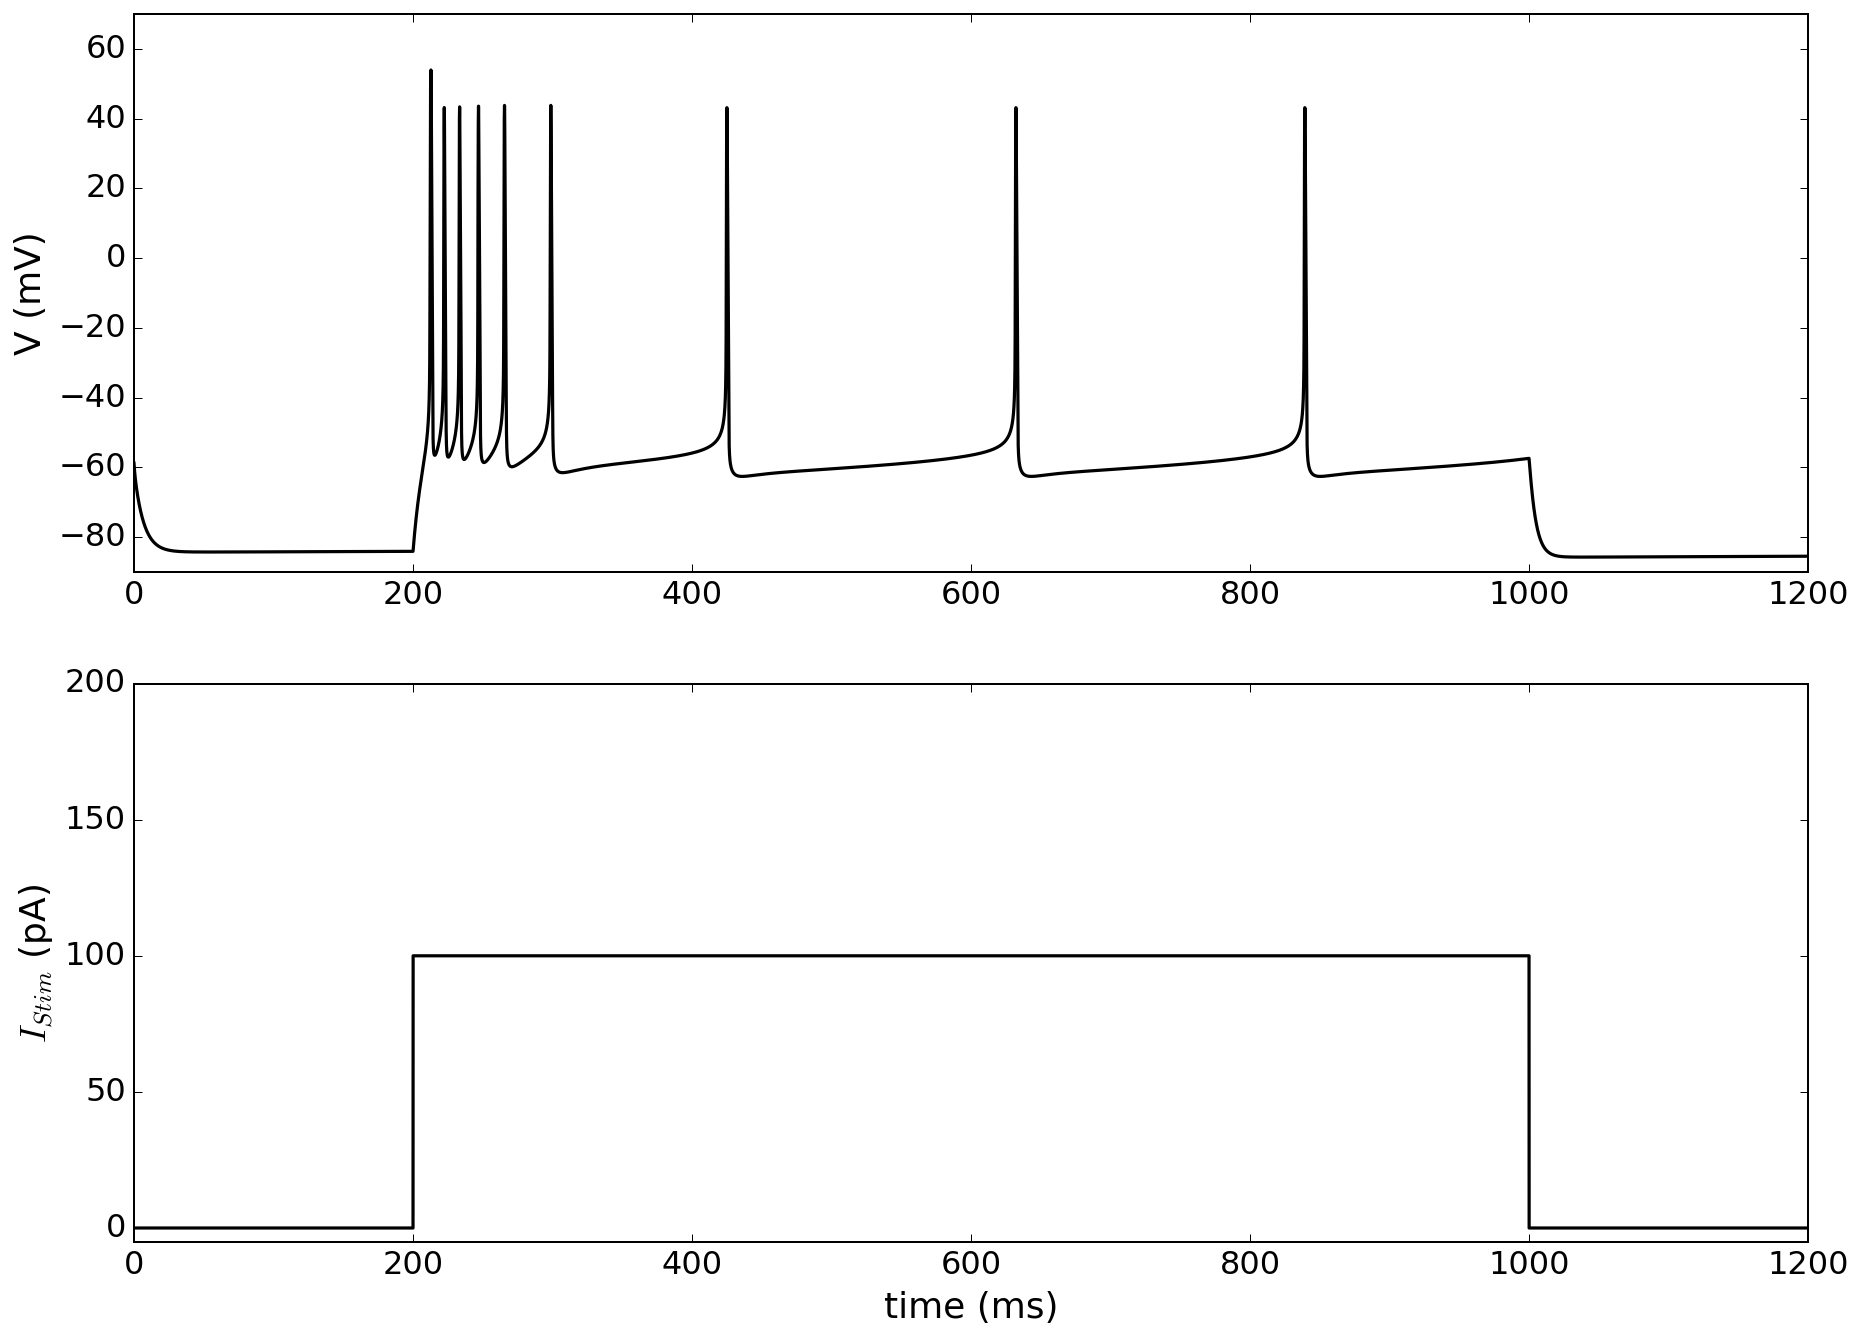

In [11]:
p1=pars(timeMax=1200,timeStep=0.003)
p1=calcReversalPotentials(p1)
p1=normalizeVolts(p1)
p1=normalizeAmps(p1)
p1['verboseSimulation']=0
p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
xx=simulate3DNeuron(p1,graph=0)

ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.ioff()
r=2; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].plot(xx['sampTimes'],xx['v'],'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-90,70)

ax1[1].plot(xx['sampTimes'],xx['iStim'],'k',label=r'$I_{Stim}$')
ax1[1].set_ylabel('$I_{Stim}$ (pA)')
ax1[1].set_ylim(-5,200)
ax1[1].set_xlabel('time (ms)');

If we plot the spiking response above on a smaller time scale and also plot each current, we can see that the model produces ion currents within the same magnitude range as those seen in CA1 PC recordings.

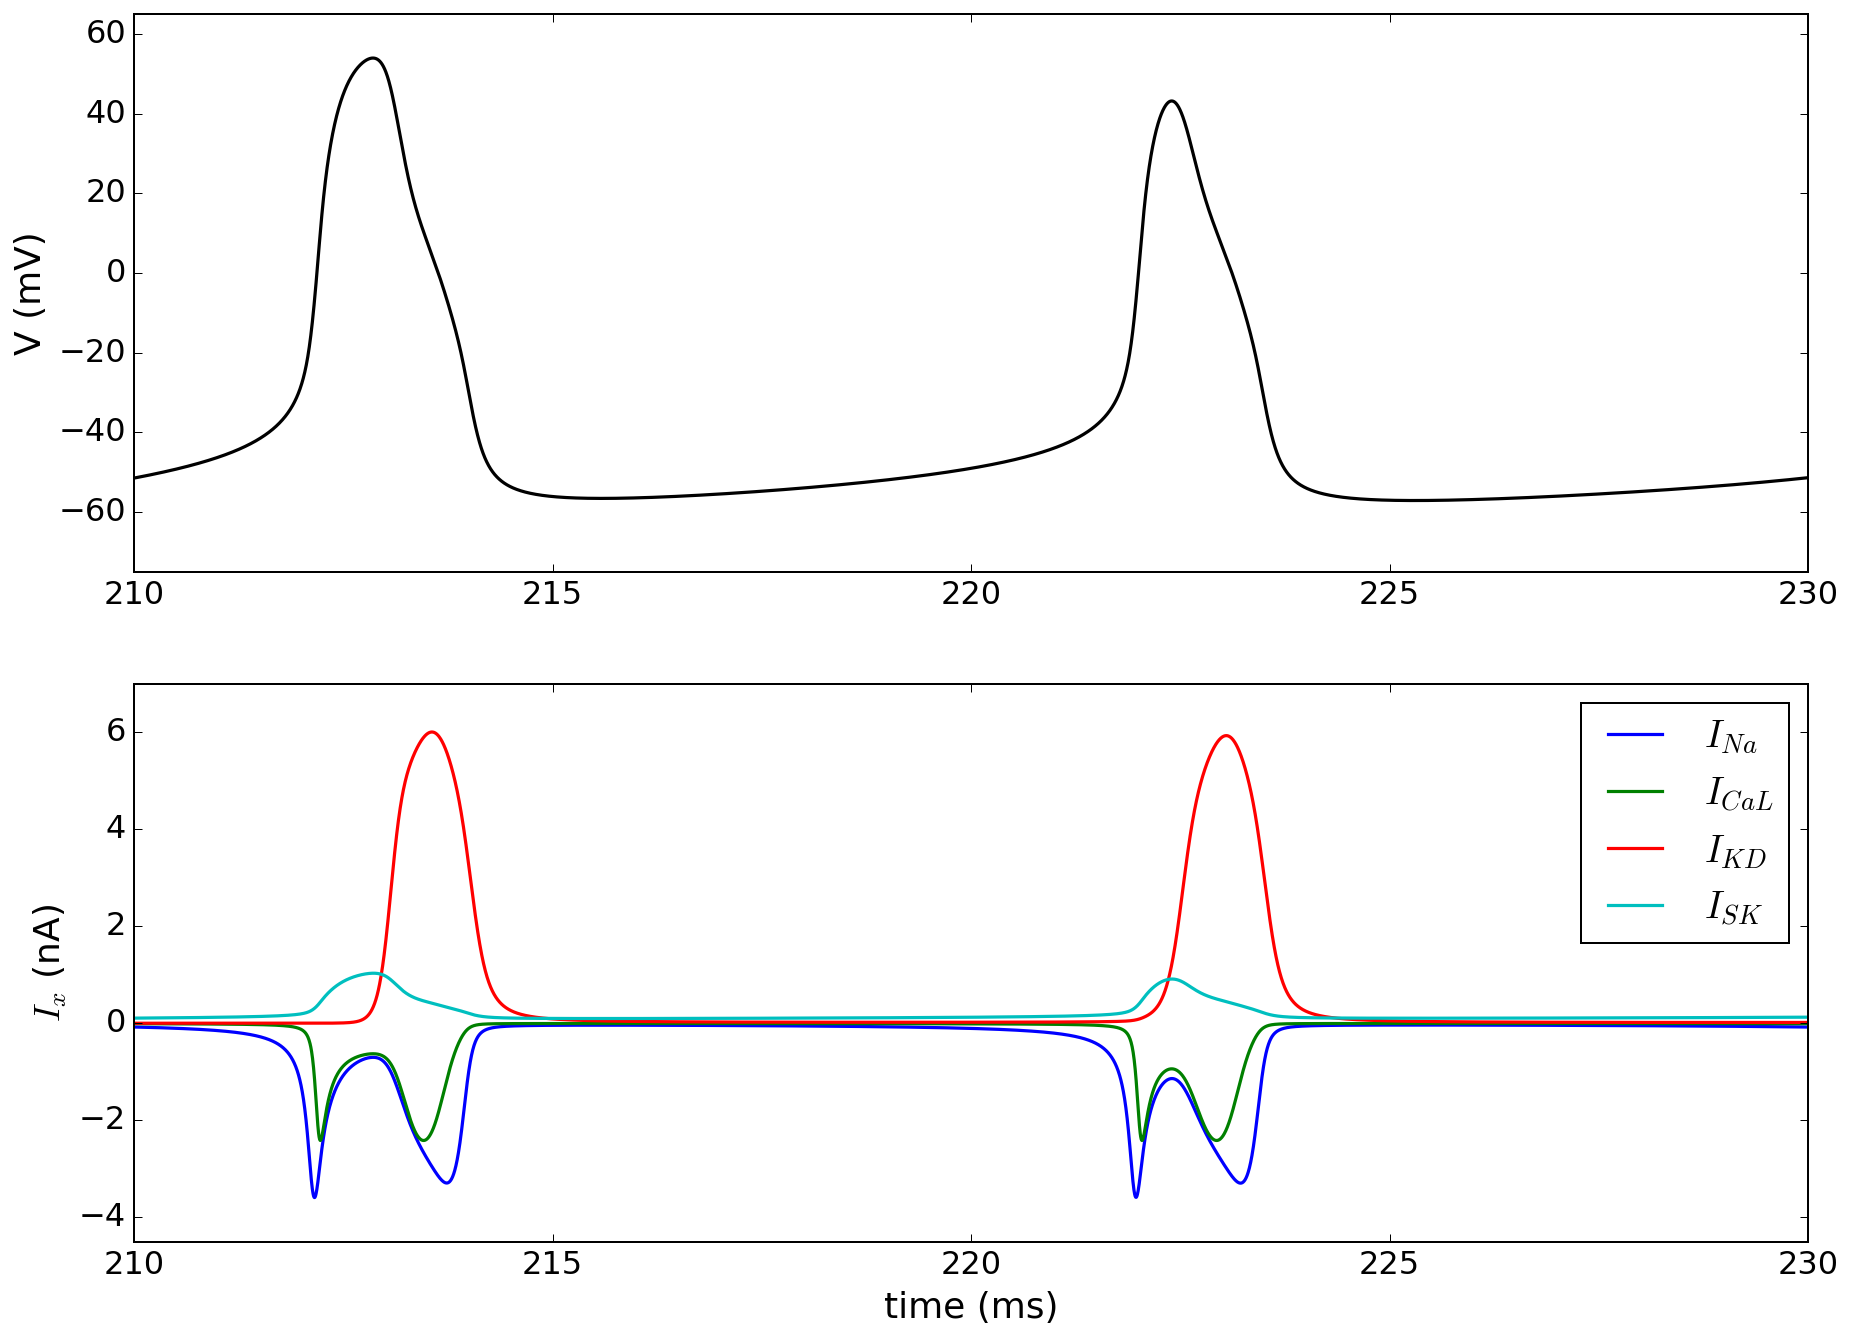

In [12]:
ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.ioff()
r=2; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].plot(xx['sampTimes'],xx['v'],'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-75,65)
ax1[0].set_xlim(210,230)

ax1[1].plot(xx['sampTimes'],xx['iNaT'],label=r'$I_{Na}$')
ax1[1].plot(xx['sampTimes'],xx['iCa12'],label=r'$I_{CaL}$')
ax1[1].plot(xx['sampTimes'],xx['iKaD'],label=r'$I_{KD}$')
ax1[1].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
ax1[1].set_ylabel('$I_{x}$ (nA)')
ax1[1].set_xlabel('time (ms)')
ax1[1].set_xlim(210,230)
ax1[1].set_ylim(-4.5,7)
ax1[1].legend(loc="upper right");

We can now run the model for different sets of parameters to explore the effects on CA1 PC firing. To compare young and old model PCs, all parameters were fixed except for the amplitude of the L-type Ca<sup>2+</sup> current, which was set to produce currents of either 3 nA or 6 nA - roughly the same magnitudes as those seen in recordings from young and old PCs, respectively. 

In [13]:
p1=pars(timeMax=1200,timeStep=0.003)
aCaLs=sc.arange(3e3,7e3,3e3)
ncals=len(aCaLs)
sims=list()
    
for n in range(ncals):
    p1['a_Ca12']=aCaLs[n]
    p1=calcReversalPotentials(p1)
    p1=normalizeVolts(p1)
    p1=normalizeAmps(p1)
    p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
    dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
    p1['verboseSimulation']=0
    xx=simulate3DNeuron(p1,graph=0)
    sims.append(xx)        

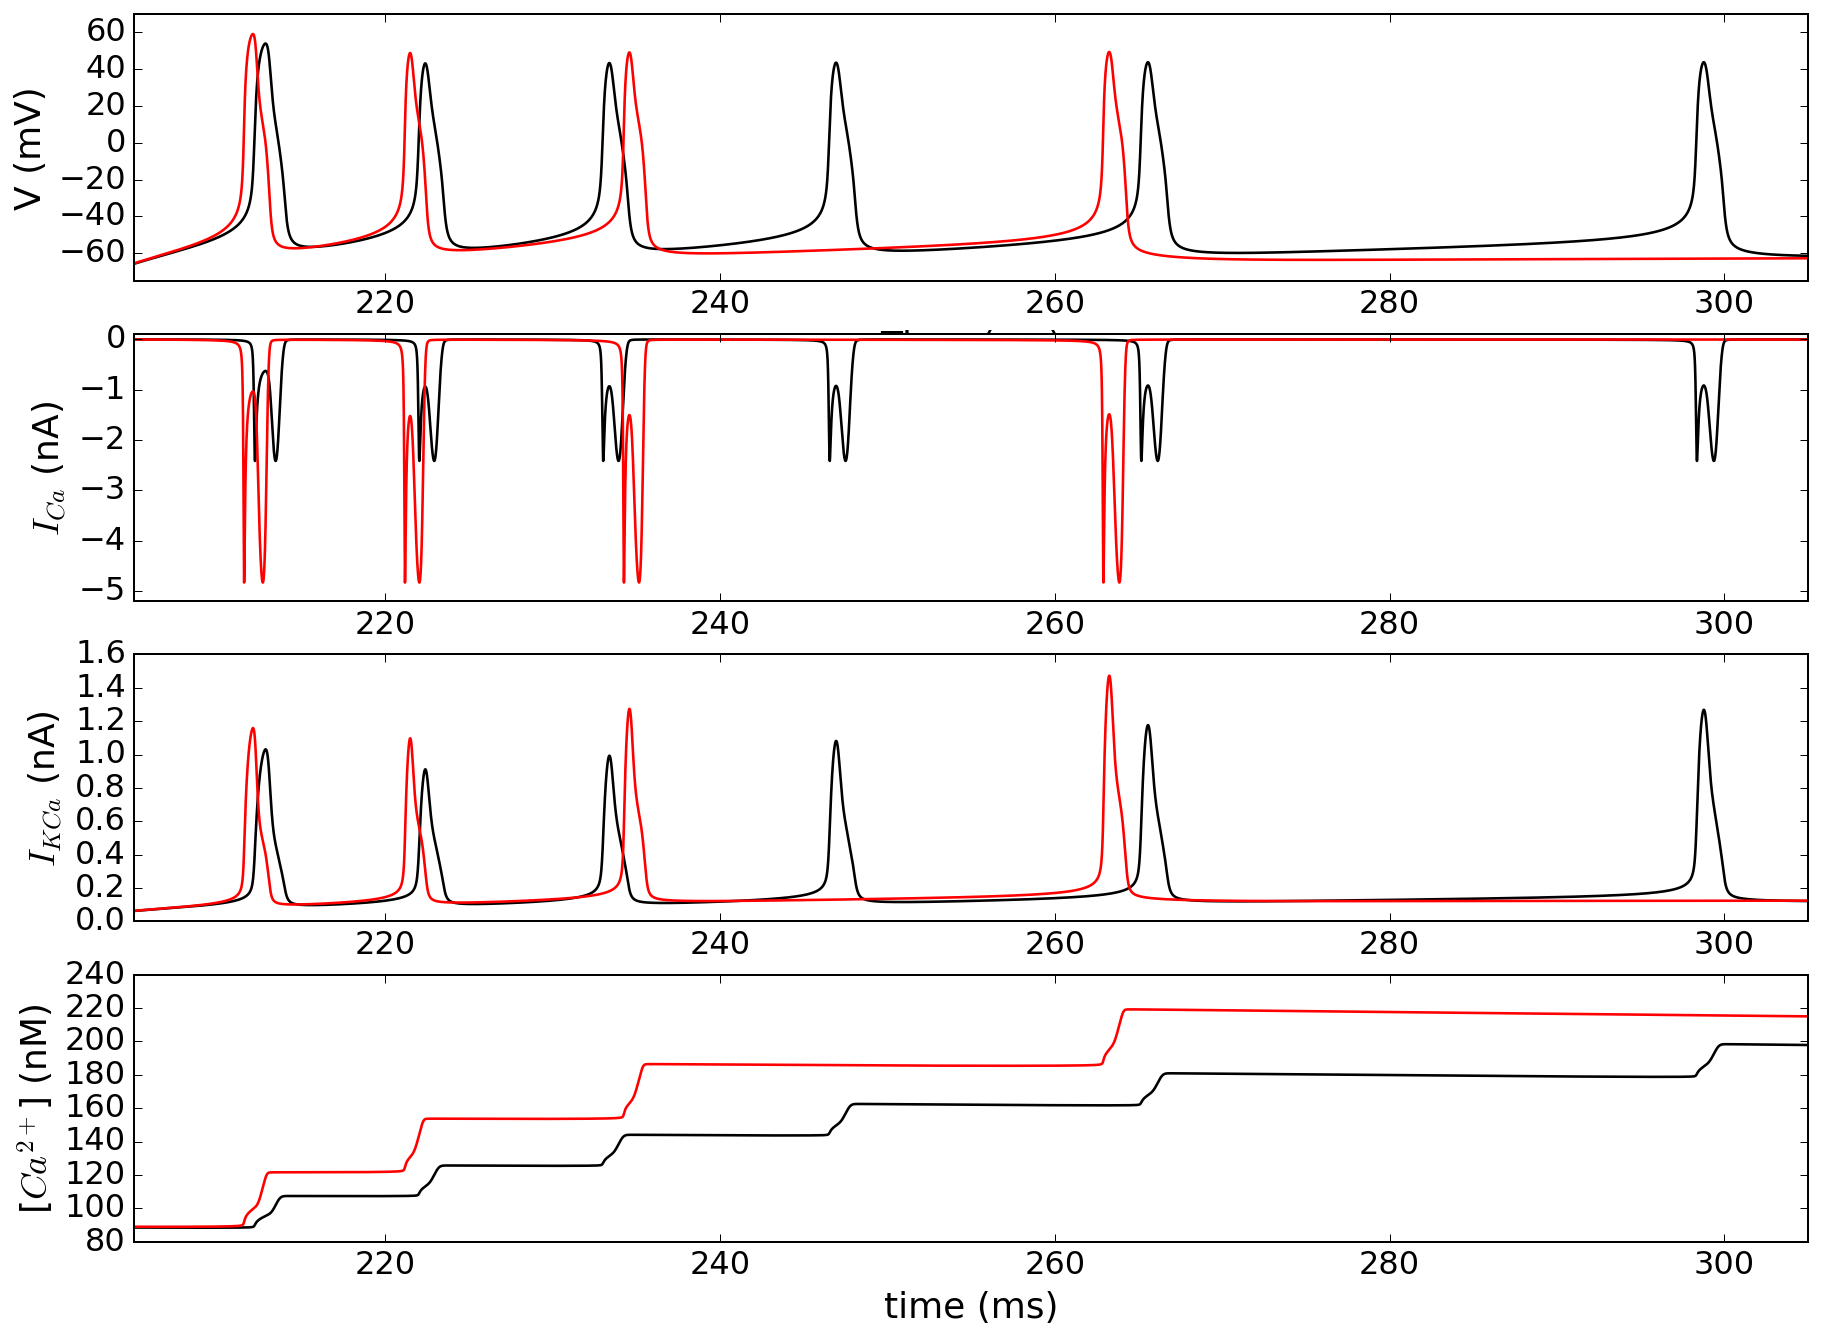

In [14]:
# plot results of previous simulations
        
ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.ioff()
r=4; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))


# right now, only thing changing is color, but can cycle through line styles and widths
ax1[0].set_prop_cycle(cycler('color', ['k', 'r']) +
                   cycler('linestyle', ['-', '-'])+
                   cycler('linewidth', ['1.3', '1.3']))
ax1[1].set_prop_cycle(cycler('color', ['k', 'r']) +
                   cycler('linestyle', ['-', '-'])+
                   cycler('linewidth', ['1.3', '1.3']))
ax1[2].set_prop_cycle(cycler('color', ['k', 'r']) +
                   cycler('linestyle', ['-', '-'])+
                   cycler('linewidth', ['1.3', '1.3']))
ax1[3].set_prop_cycle(cycler('color', ['k', 'r']) +
                   cycler('linestyle', ['-', '-'])+
                   cycler('linewidth', ['1.3', '1.3']))


for n in range(ncals):
    xx=sims[n]
    ax1[0].plot(xx['sampTimes'],xx['v'])
    ax1[0].set_xlabel('Time (ms)')
    ax1[0].set_ylabel('V (mV)')
    ax1[0].set_ylim(-75,70)
    ax1[0].set_xlim(205,305)
    ax1[1].plot(xx['sampTimes'],xx['iCa12'],label=r'$I_{CaL}$')
    ax1[1].set_ylabel('$I_{Ca}$ (nA)')
    ax1[1].set_ylim(-5.2,0.1)
    ax1[1].set_xlim(205,305)
    ax1[2].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
    ax1[2].set_ylabel('$I_{KCa}$ (nA)')
    ax1[2].set_xlim(205,305)
    ax1[2].set_ylim(0,1.6)
    scale_y=1e-6
    ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax1[3].yaxis.set_major_formatter(ticks_y)
    ax1[3].plot(xx['sampTimes'],xx['c'])
    ax1[3].set_xlim(205,305)
    ax1[3].set_xlabel('time (ms)')
    ax1[3].set_ylabel('[$Ca^{2+}$] (nM)')

This change in Ca<sup>2+</sup> channel density reproduces differences in spike frequency adaptation between young and old PCs. Increased Ca<sup>2+</sup> channel density causes the initial number of spikes fired in the first 100 ms after stimulus onset to decrease from 6 to 4, and increases adaptation, thereby slowing firing to a greater extent in the aged PCs for the remaining period of current injection. This decreased excitability results from increased Ca<sup>2+</sup>-dependent potassium channel activation. Compare the response above to recordings in Moyer et al. (1992).

In [23]:
p1=pars(timeMax=5000,timeStep=0.003)
p1['upStart']=200.0
p1['upStop']=200.001
p1['dnStart']=300.0
p1['dnStop']=300.001
aCaLs=sc.arange(3e3,7e3,3e3)
stims=sc.arange(80,110,20)
nstims=len(stims)
sims=list()

for n in sc.arange(nstims):
    p1['a_Ca12']=aCaLs[n]        
    p1['rampAmp']=stims[n]        
    p1=calcReversalPotentials(p1)
    p1=normalizeVolts(p1)
    p1=normalizeAmps(p1)
    p1['verboseSimulation']=0
    p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
    dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
    xx=simulate3DNeuron(p1,graph=0)
    sims.append(xx)

## Afterhyperpolarizations

CA1 PCs stimulated with a short square-pulse current injection into the soma can be induced to fire a quick burst of spikes, followed by a period during which the membrane potential dips below the resting membrane potential and remains there for hundres of milliseconds to seconds. This period is known as an after-hyperpolarization (AHP). Experimental studies have shown that aged CA1 PCs have larger AHPs than young cells, causing decreased excitability and spike failure. As done in experiments, we adjusted the current stimulation such that it induced a burst of four spikes in both young and old cells. This required the current amplitude to be slightly increased (20 pA higher) for older cells due to their decreased excitability. Since the same number of spikes is generated in each cell, their subsequent AHPs can be compared.

It is important to note that for the following simulations, the amplitudes of the Na<sup>+</sup>, delayed rectifier K<sup>+</sup>, and Ca<sup>2+</sup>-dependent K<sup>+</sup> currents were all increased relative to the previous simulations, but still within the physiological range. (Note: Don't forget to also reset the Na<sup>+</sup>/K<sup>+</sup> pump current amplitude, since it is a multiple of <i>a_NaT</i>.)  The amplitude of the Ca<sup>2+</sup> current and Ca<sup>2+</sup> handling was not changed. Before comparing young and old cells, we examine the first three spikes in the burst on a small time scale, along with the plotted currents to check their amplitudes and time course.

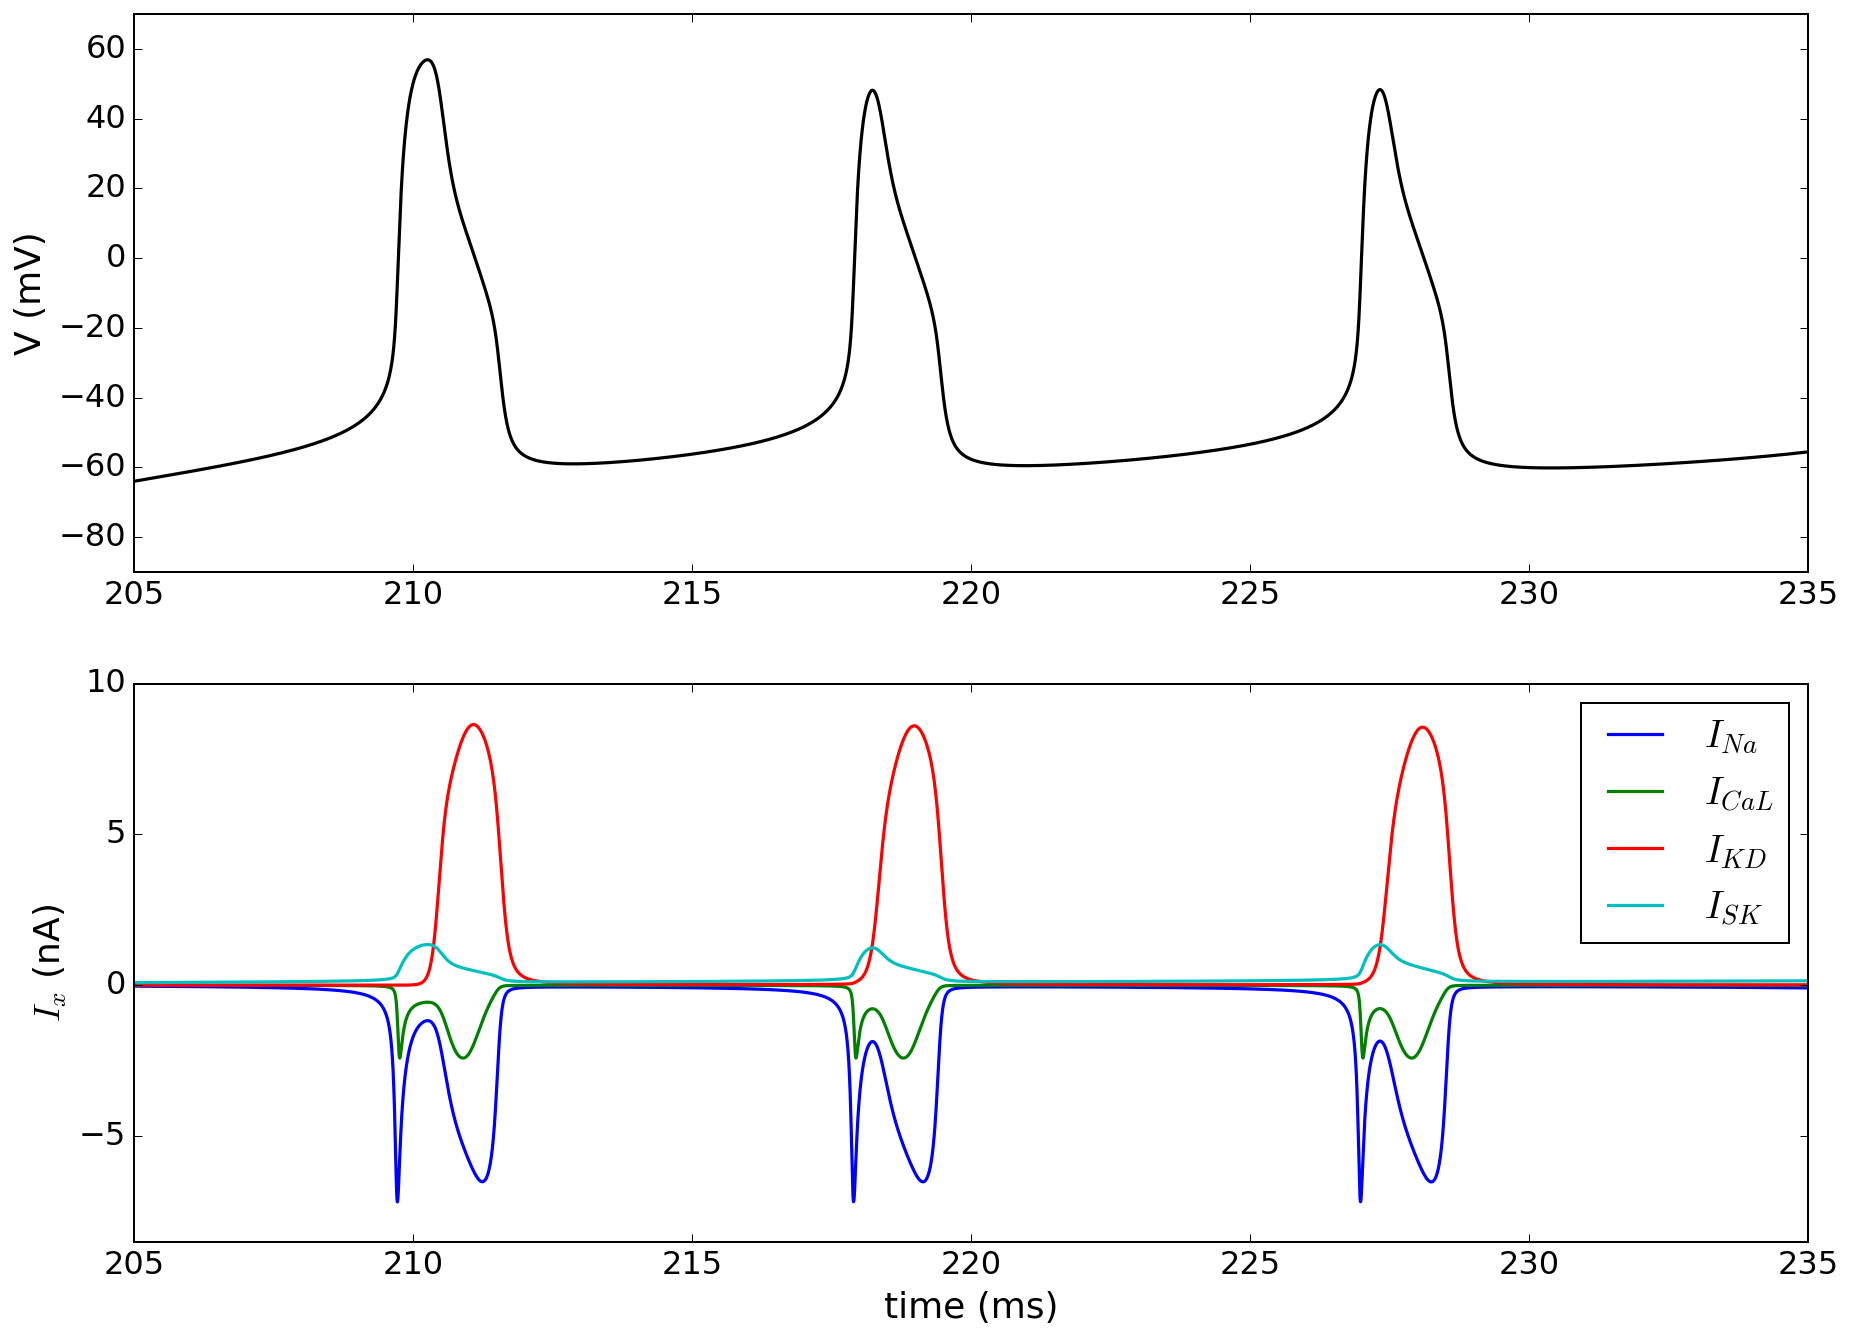

In [17]:
p1=pars(timeMax=5000,timeStep=0.003)
p1['a_NaT']=2e3
p1['a_Ca12']=3e3
p1['a_KaD']=2e4
p1['a_KaSK']=1e3
p1['a_NaKa']=0.01*p1['a_NaT']
p1['upStart']=200.0
p1['upStop']=200.001
p1['dnStart']=300.0
p1['dnStop']=300.001

p1=calcReversalPotentials(p1)
p1=normalizeVolts(p1)
p1=normalizeAmps(p1)
p1['verboseSimulation']=0
p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
xx=simulate3DNeuron(p1,graph=0)

ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.rcParams['lines.linewidth'] = 1.6
plt.ioff()
r=2; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].plot(xx['sampTimes'],xx['v'],'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-90,70)
ax1[0].set_xlim(205,235)

ax1[1].plot(xx['sampTimes'],xx['iNaT'],label=r'$I_{Na}$')
ax1[1].plot(xx['sampTimes'],xx['iCa12'],label=r'$I_{CaL}$')
ax1[1].plot(xx['sampTimes'],xx['iKaD'],label=r'$I_{KD}$')
ax1[1].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
ax1[1].set_ylabel('$I_{x}$ (nA)')
ax1[1].set_xlabel('time (ms)')
ax1[1].set_xlim(205,235)
ax1[1].set_ylim(-8.5,10)
ax1[1].legend(loc="upper right");

To compare young and old cells, we once again fix parameters except for the amplitude of the L-type Ca<sup>2+</sup> current, which was set to produce currents of either 3 nA or 6 nA. The young model cell is stimulated with 75 nA to produce a burst of four spikes, while the old model cell is stimulated with 95 nA to produce the same number of spikes. 

In [20]:
aCaLs=sc.arange(3e3,7e3,3e3)
stims=sc.arange(75,100,20)
nstims=len(stims)
sims=list()

for n in sc.arange(nstims):
    p1['a_Ca12']=aCaLs[n]        
    p1['rampAmp']=stims[n]        
    p1=calcReversalPotentials(p1)
    p1=normalizeVolts(p1)
    p1=normalizeAmps(p1)
    p1['verboseSimulation']=0
    p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
    dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
    xx=simulate3DNeuron(p1,graph=0)
    sims.append(xx)

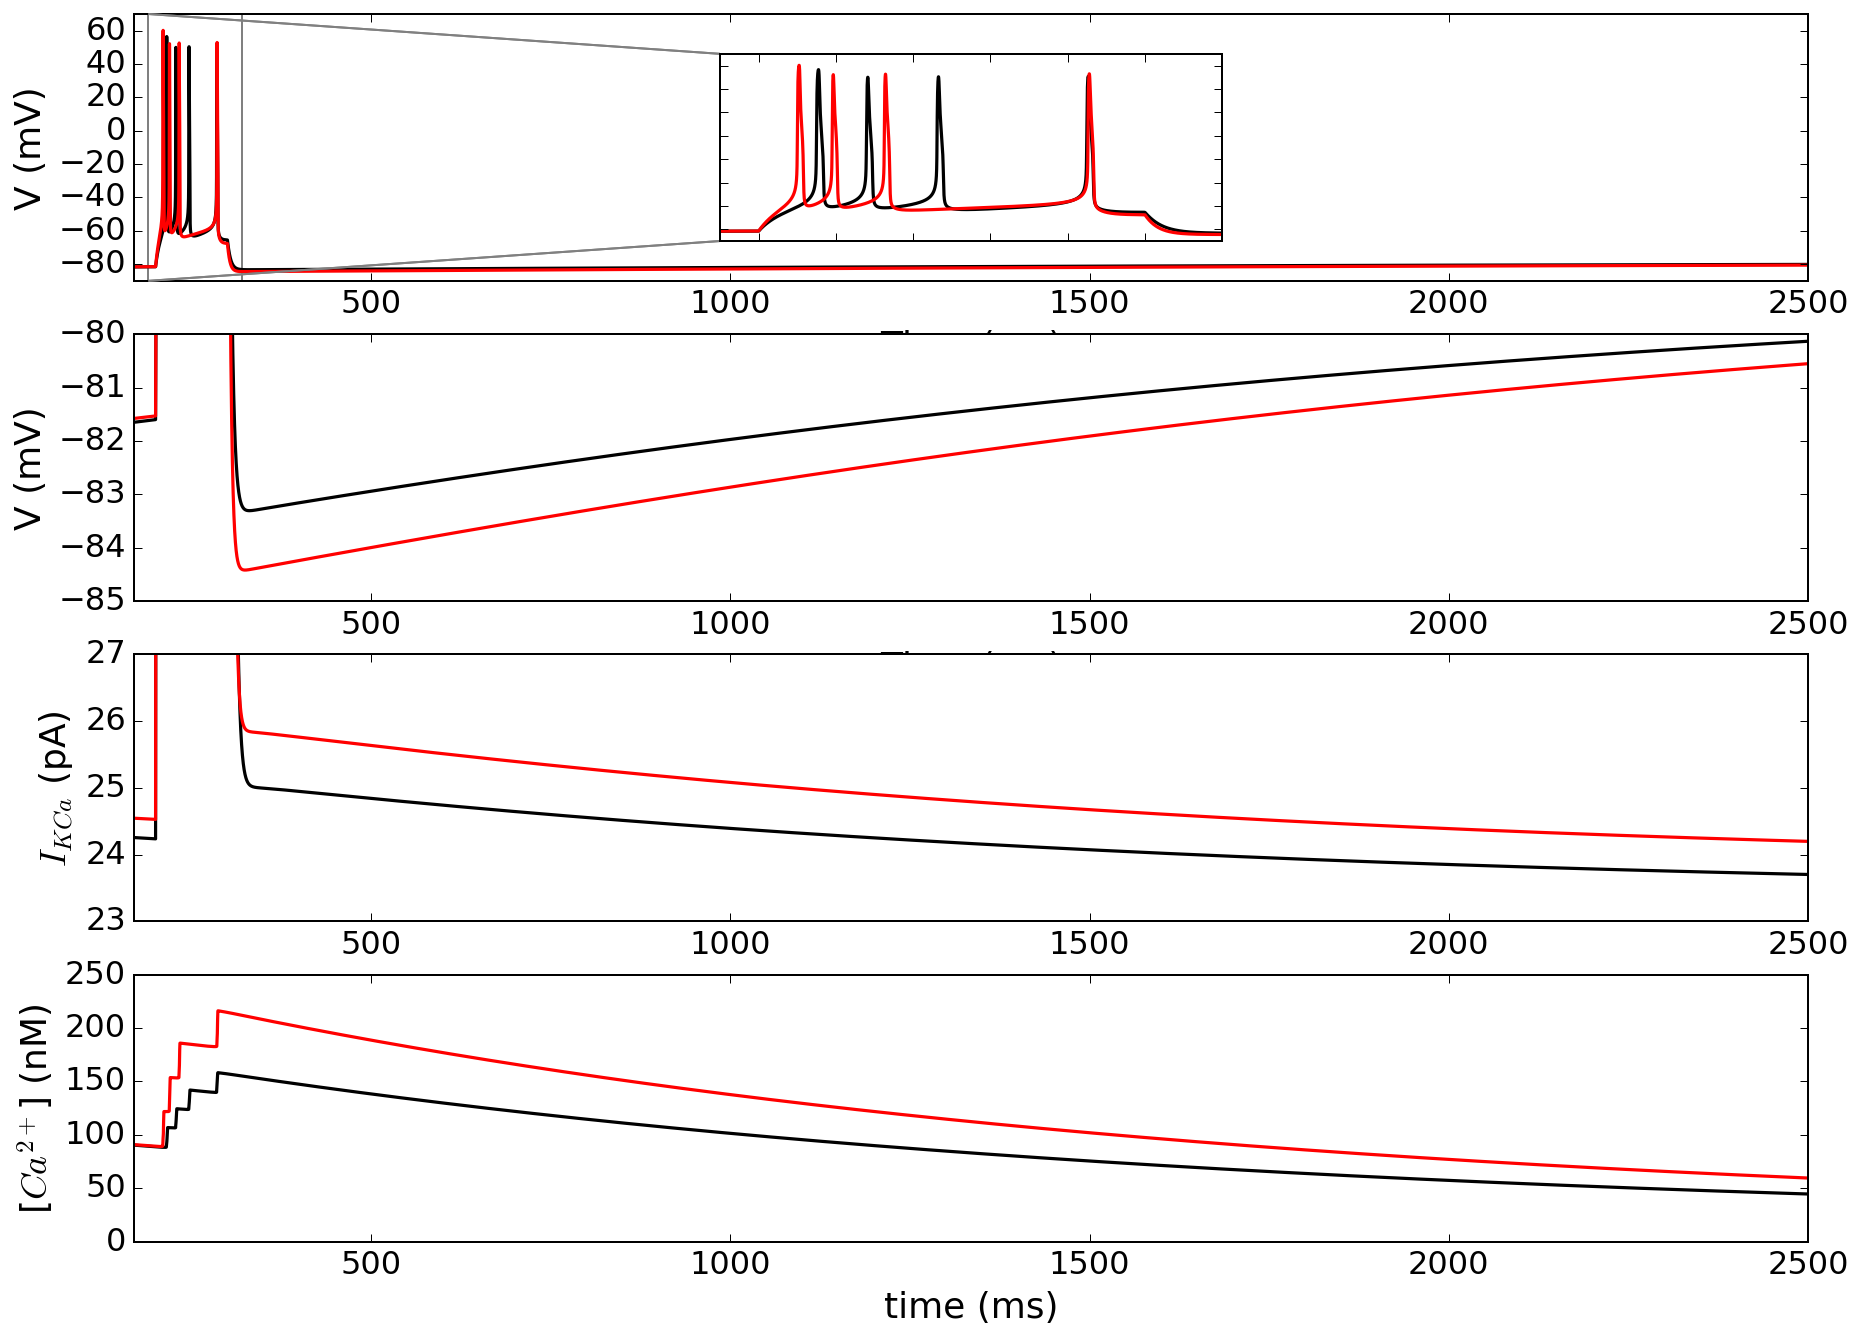

In [24]:
# plot and compare AHPs in young and old PCs
ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.ioff()
r=4; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].set_color_cycle(['black','red'])   
ax1[1].set_color_cycle(['black','red'])
ax1[2].set_color_cycle(['black','red'])   
ax1[3].set_color_cycle(['black','red'])

axins = inset_axes(ax1[0],
                        width="30%", # width = 30% of parent_bbox
                        height=1.3, # height : 1 inch
                        loc=10)
axins.set_color_cycle(['black','red'])

for n in range(nstims):
    xx=sims[n]
    ax1[0].plot(xx['sampTimes'],xx['v'])
    ax1[0].set_xlabel('Time (ms)')
    ax1[0].set_ylabel('V (mV)')
    ax1[0].set_ylim(-90,70)
    ax1[0].set_xlim(170,2500)
        
    mark_inset(ax1[0], axins, loc1=2, loc2=3, fc="none", ec="0.5")
    axins.plot(xx['sampTimes'],xx['v'])
    x1, x2, y1, y2 = 190, 320, -90, 70
    axins.set_xlim(x1, x2) 
    axins.set_ylim(y1, y2) 
    plt.yticks(visible=False)
    plt.xticks(visible=False)

    ax1[1].plot(xx['sampTimes'],xx['v'])
    ax1[1].set_xlabel('Time (ms)')
    ax1[1].set_ylabel('V (mV)')
    ax1[1].set_ylim(-85,-80)
    ax1[1].set_xlim(170,2500)
    
    scale_y1=1e-3
    ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y1))
    ax1[2].yaxis.set_major_formatter(ticks_y)
    ax1[2].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
    ax1[2].set_ylabel('$I_{KCa}$ (pA)')
    ax1[2].set_xlim(170,2500)
    ax1[2].set_ylim(0.023,0.027)
    ticks=sc.arange(0.023,0.0275,0.001)
    ax1[2].set_yticks(ticks)
    
    scale_y2=1e-6
    ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y2))
    ax1[3].yaxis.set_major_formatter(ticks_y)
    ax1[3].plot(xx['sampTimes'],xx['c'])
    ax1[3].set_xlim(170,2500)
    ax1[3].set_xlabel('time (ms)')
    ax1[3].set_ylabel('[$Ca^{2+}$] (nM)');

AHPs are observed in both young and old model PCs, and with relative magnitudes similar to those observed in recordings. The increase in the Ca<sup>2+</sup> channel expression in old model cells is sufficient to produce larger AHPs than seen in young cells. 

## Conditional bursting

Experiments show that some CA1 PCs burst in response to current injection, a behavior known as conditional bursting because the cells only display this behavior in the presence of a stimulus. To reproduce this behavior in the model, we increased the amplitude of the Na<sup>+</sup> and delayed rectifier K<sup>+</sup> currents, and increased the rate of K<sup>+</sup> channel activation. We also altered the Ca<sup>2+</sup> handling. 

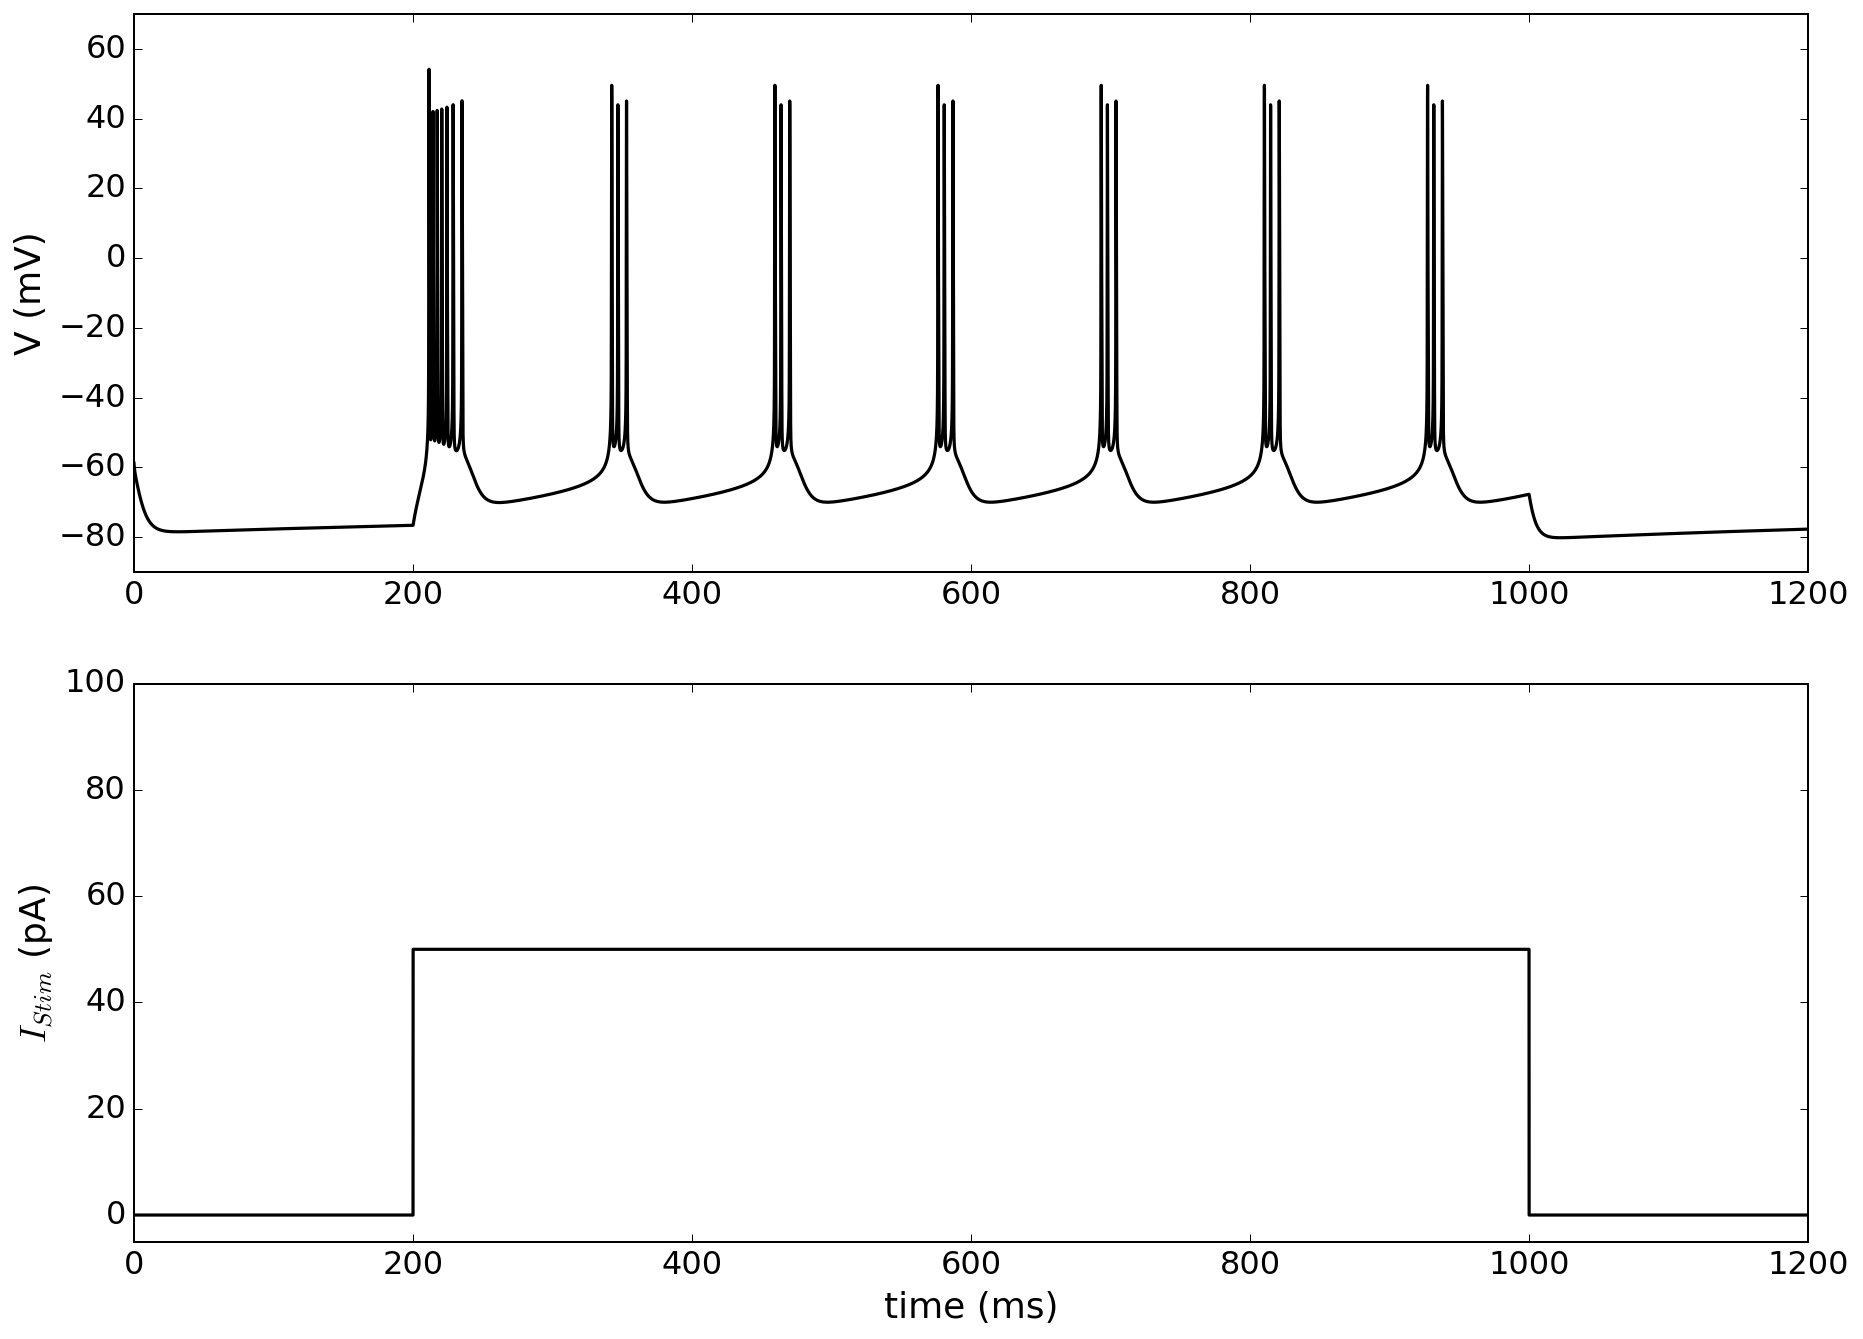

In [25]:
p1['a_NaT']=3e3
p1['a_KaD']=2.5e4
p1['a_NaKa']=0.01*p1['a_NaT']
p1['a_Ca12']=3e3
p1['rateP_KaD']=2.5
p1['rampAmp']=50.0
p1['kc_Ca']=2e-8
p1['rc_Ca']=4e-3
p1['upStart']=200.0
p1['upStop']=200.001
p1['dnStart']=1000.0
p1['dnStop']=1000.001
sims=list()

p1=calcReversalPotentials(p1)
p1=normalizeVolts(p1)
p1=normalizeAmps(p1)
p1['verboseSimulation']=0
p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
xx=simulate3DNeuron(p1,graph=0)

ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.rcParams['lines.linewidth'] = 1.6
plt.ioff()
r=2; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].plot(xx['sampTimes'],xx['v'],'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-90,70)
ax1[0].set_xlim(0,1200)

ax1[1].plot(xx['sampTimes'],xx['iStim'],'k',label=r'$I_{Stim}$')
ax1[1].set_ylabel('$I_{Stim}$ (pA)')
ax1[1].set_xlabel('time (ms)')
ax1[1].set_xlim(0,1200)
ax1[1].set_ylim(-5,100);

To compare the responses of young and old cells, we varied the Ca<sup>2+</sup> channel density as before. 

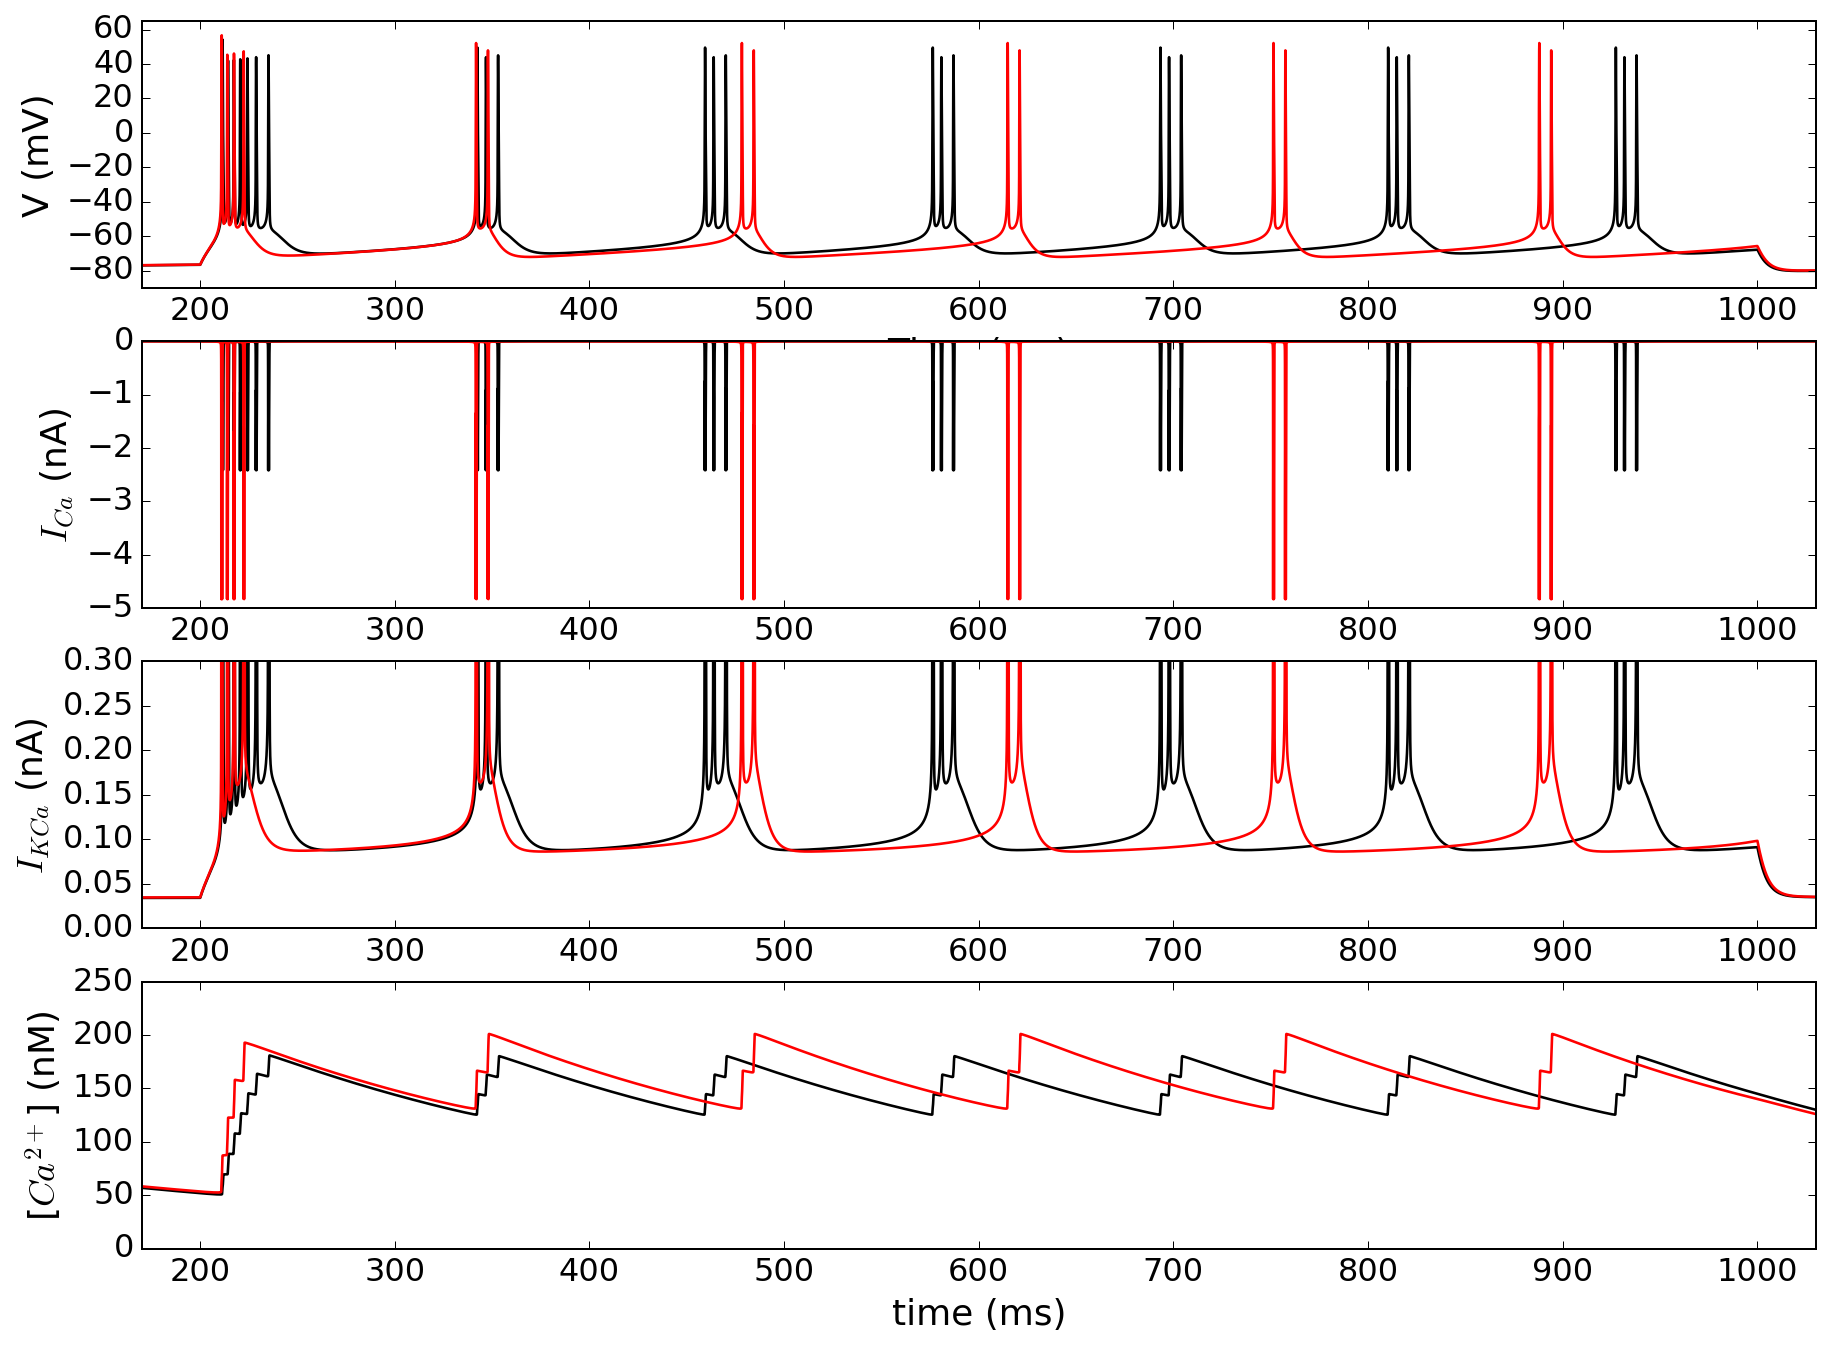

In [26]:
for n in range(ncals):
    p1['a_Ca12']=aCaLs[n]
    p1=calcReversalPotentials(p1)
    p1=normalizeVolts(p1)
    p1=normalizeAmps(p1)
    p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
    dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
    p1['verboseSimulation']=0
    xx=simulate3DNeuron(p1,graph=0)
    sims.append(xx)    
        
ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.rcParams['lines.linewidth'] = 1.3
plt.ioff()
r=4; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].set_color_cycle(['black','red'])   
ax1[1].set_color_cycle(['black','red'])
ax1[2].set_color_cycle(['black','red'])   
ax1[3].set_color_cycle(['black','red'])

for n in range(nstims):
    xx=sims[n]
    ax1[0].plot(xx['sampTimes'],xx['v'])
    ax1[0].set_xlabel('Time (ms)')
    ax1[0].set_ylabel('V (mV)')
    ax1[0].set_ylim(-90,65)
    ax1[0].set_xlim(170,1030)
    ax1[1].plot(xx['sampTimes'],xx['iCa12'],label=r'$I_{CaL}$')
    ax1[1].set_ylabel('$I_{Ca}$ (nA)')
    ax1[1].set_xlim(170,1030)
    ax1[2].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
    ax1[2].set_ylabel('$I_{KCa}$ (nA)')
    ax1[2].set_xlim(170,1030)
    ax1[2].set_ylim(0,0.3)
    scale_y=1e-6
    ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax1[3].yaxis.set_major_formatter(ticks_y)
    ax1[3].plot(xx['sampTimes'],xx['c'])
    ax1[3].set_xlim(170,1030)
    ax1[3].set_xlabel('time (ms)')
    ax1[3].set_ylabel('[$Ca^{2+}$] (nM)');

Due to the increased Ca<sup>2+</sup> entry, aged cells fire earlier than young cells. However, they appear to "burn out" quicker too, firing less spikes per burst due to the repolarizing/hyperpolarizing effects of the Ca<sup>2+</sup>-dependent K<sup>+</sup> current. As intracellular Ca<sup>2+</sup> increases and stays elevated, the activity of the aged cell is slowed and it fires one less burst than the young cell during the stimulation period. 

Now, let's compare the responses of conditionally-bursting aged and young cells to different stimulus amplitudes. The cells are each stimulated with 10, 25, 40, 65, 80, and 95 pA. 

In [27]:
# run the model for different stimulation amplitudes and Ca channel densities
aCaLs=sc.arange(3e3,7e3,3e3)
ncals=len(aCaLs)
aStims=sc.arange(10,100,15)
nStims=len(aStims)
sims=list()

for i in range(nStims):
    p1['rampAmp']=aStims[i]
    p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
        dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
    sims.append(list())
    for n in range(ncals):            
        p1['a_Ca12']=aCaLs[n]
        p1=calcReversalPotentials(p1)
        p1=normalizeVolts(p1)
        p1=normalizeAmps(p1)       
        p1['verboseSimulation']=0
        xx=simulate3DNeuron(p1,graph=0)
        sims[i].append(xx)                

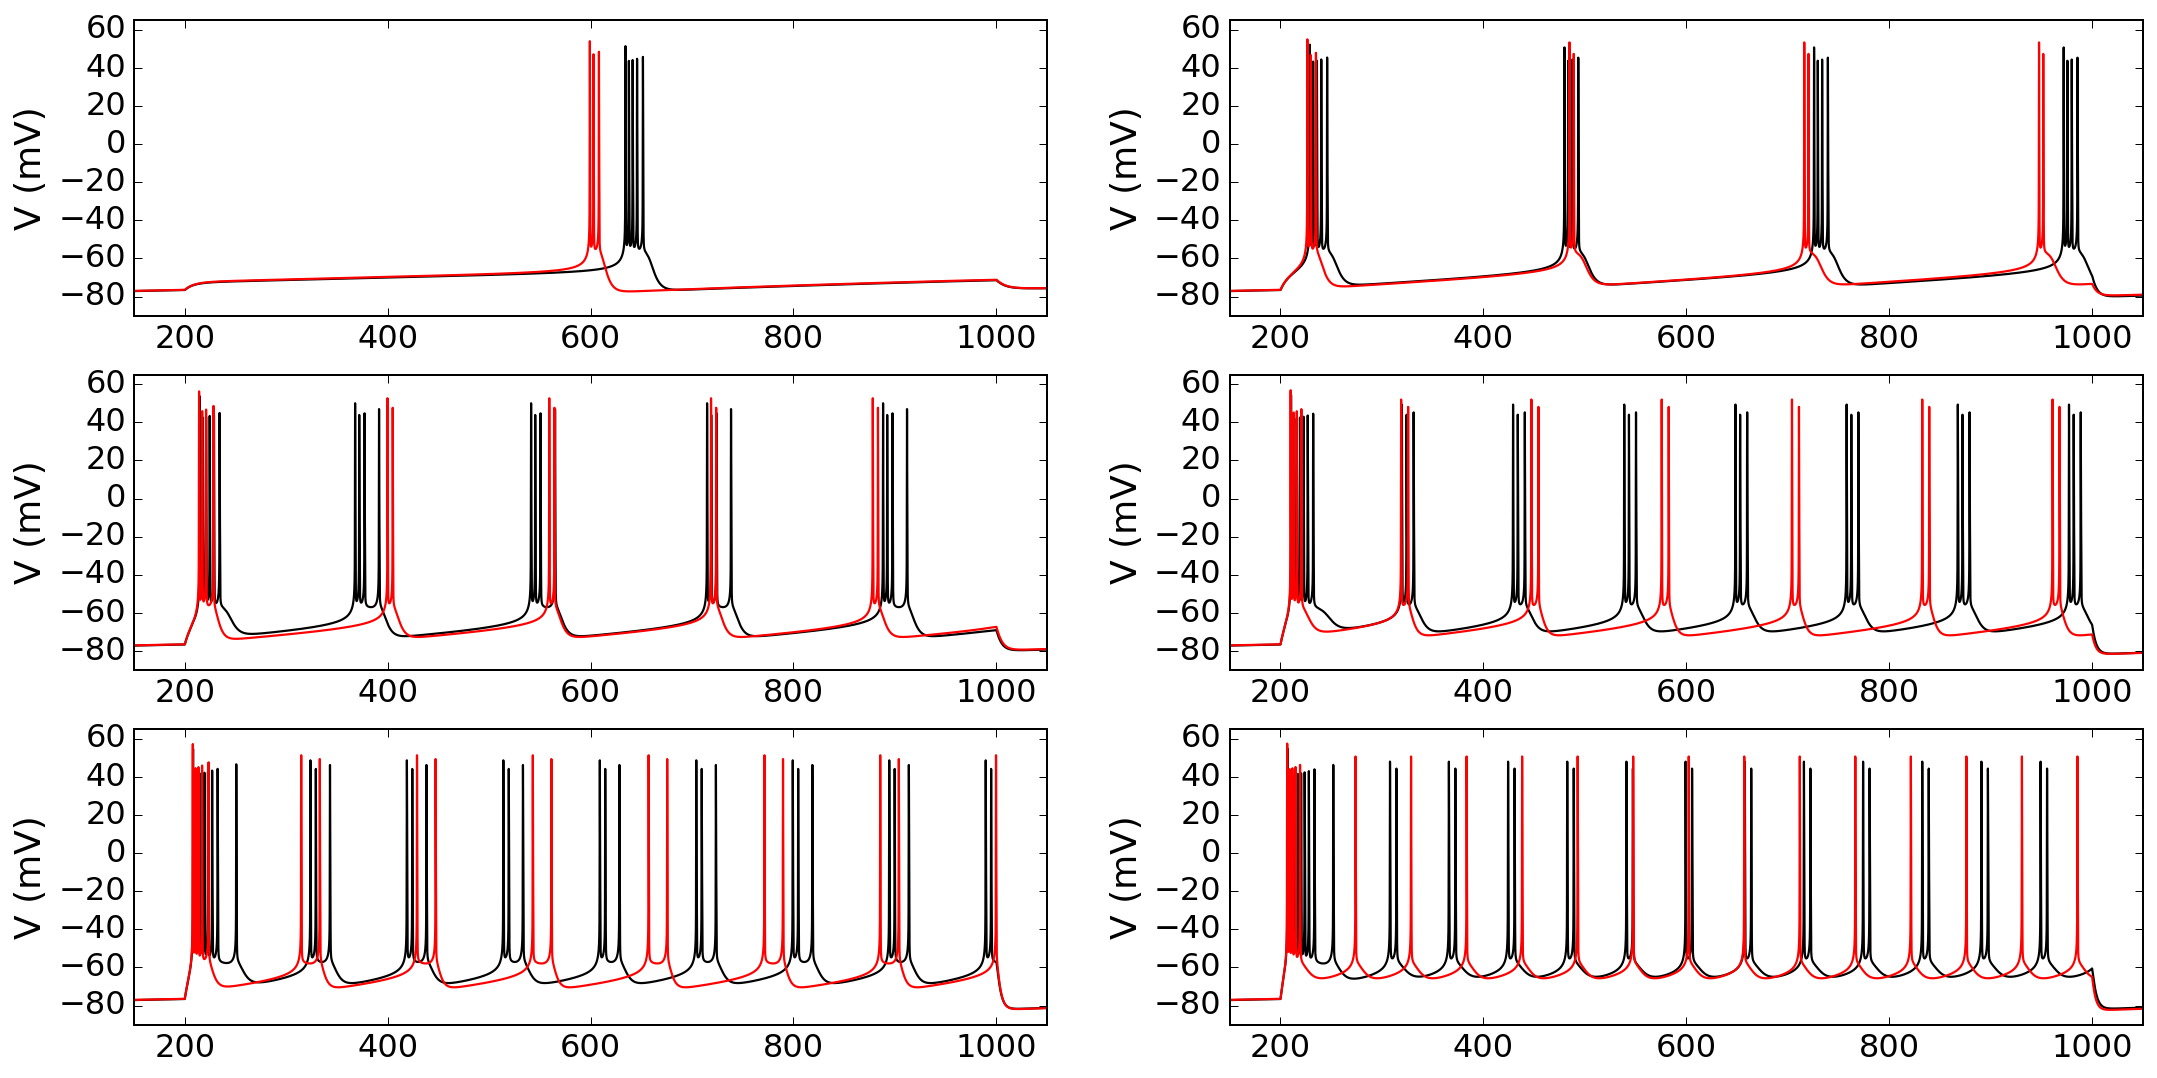

In [28]:
# plot the results of the simulations above
ax1=list()
fig1=plt.figure(figsize=(18,9))
plt.rcParams['lines.linewidth'] = 1.1
plt.ioff()
r=3; c=2
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))
    
for i in range(nStims):
    ax1[i].set_color_cycle(['black','red'])
    for n in range(ncals):
        xx=sims[i][n]
        ax1[i].plot(xx['sampTimes'],xx['v'])
    ax1[i].set_ylabel('V (mV)')
    ax1[i].set_ylim(-90,65)
    ax1[i].set_xlim(150,1050);

Again, we see that the aged cell fires earlier, but with fewer spikes per burst. At low stimulus amplitudes (up to 40 pA in the example above), the aged cell fires the same number of bursts as the young cell during the stimulation period, although with different timing. However, at higher stimulation amplitudes (65 pA in the example above), the aged cell is no longer able to keep up and fires one less burst than the young cell. At even higher stimulation amplitudes, the aged cells fails to fire proper bursts after the initial one and now fires widely-spaced doublets (80 pA) or only single spikes (95 pA).

## Spontaneous bursting

Experiments have shown that some CA1 pyramidal cells burst spontaneously in the absence of any current injection (Golomb et al., 2006). To reproduce this firing behavior, we lowered slightly the delayed rectifier K<sup>+</sup> and Ca<sup>+</sup>-dependent K<sup>+</sup> channel densities, as well as the rate of activation for the delayed rectifier. Note that the stimulation amplitude is set to 0 pA.

In [29]:
# redefine parameters to produce endogenous bursting and compare aged and young cells
p1['a_KaD']=2.1e4
p1['a_KaSK']=7.5e2
p1['a_Ca12']=3e3
p1['rateP_KaD']=1.5
p1['rampAmp']=0.0
sims=list()

p1=calcReversalPotentials(p1)
p1=normalizeVolts(p1)
p1=normalizeAmps(p1)
p1['verboseSimulation']=0
p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
xx=simulate3DNeuron(p1,graph=0)

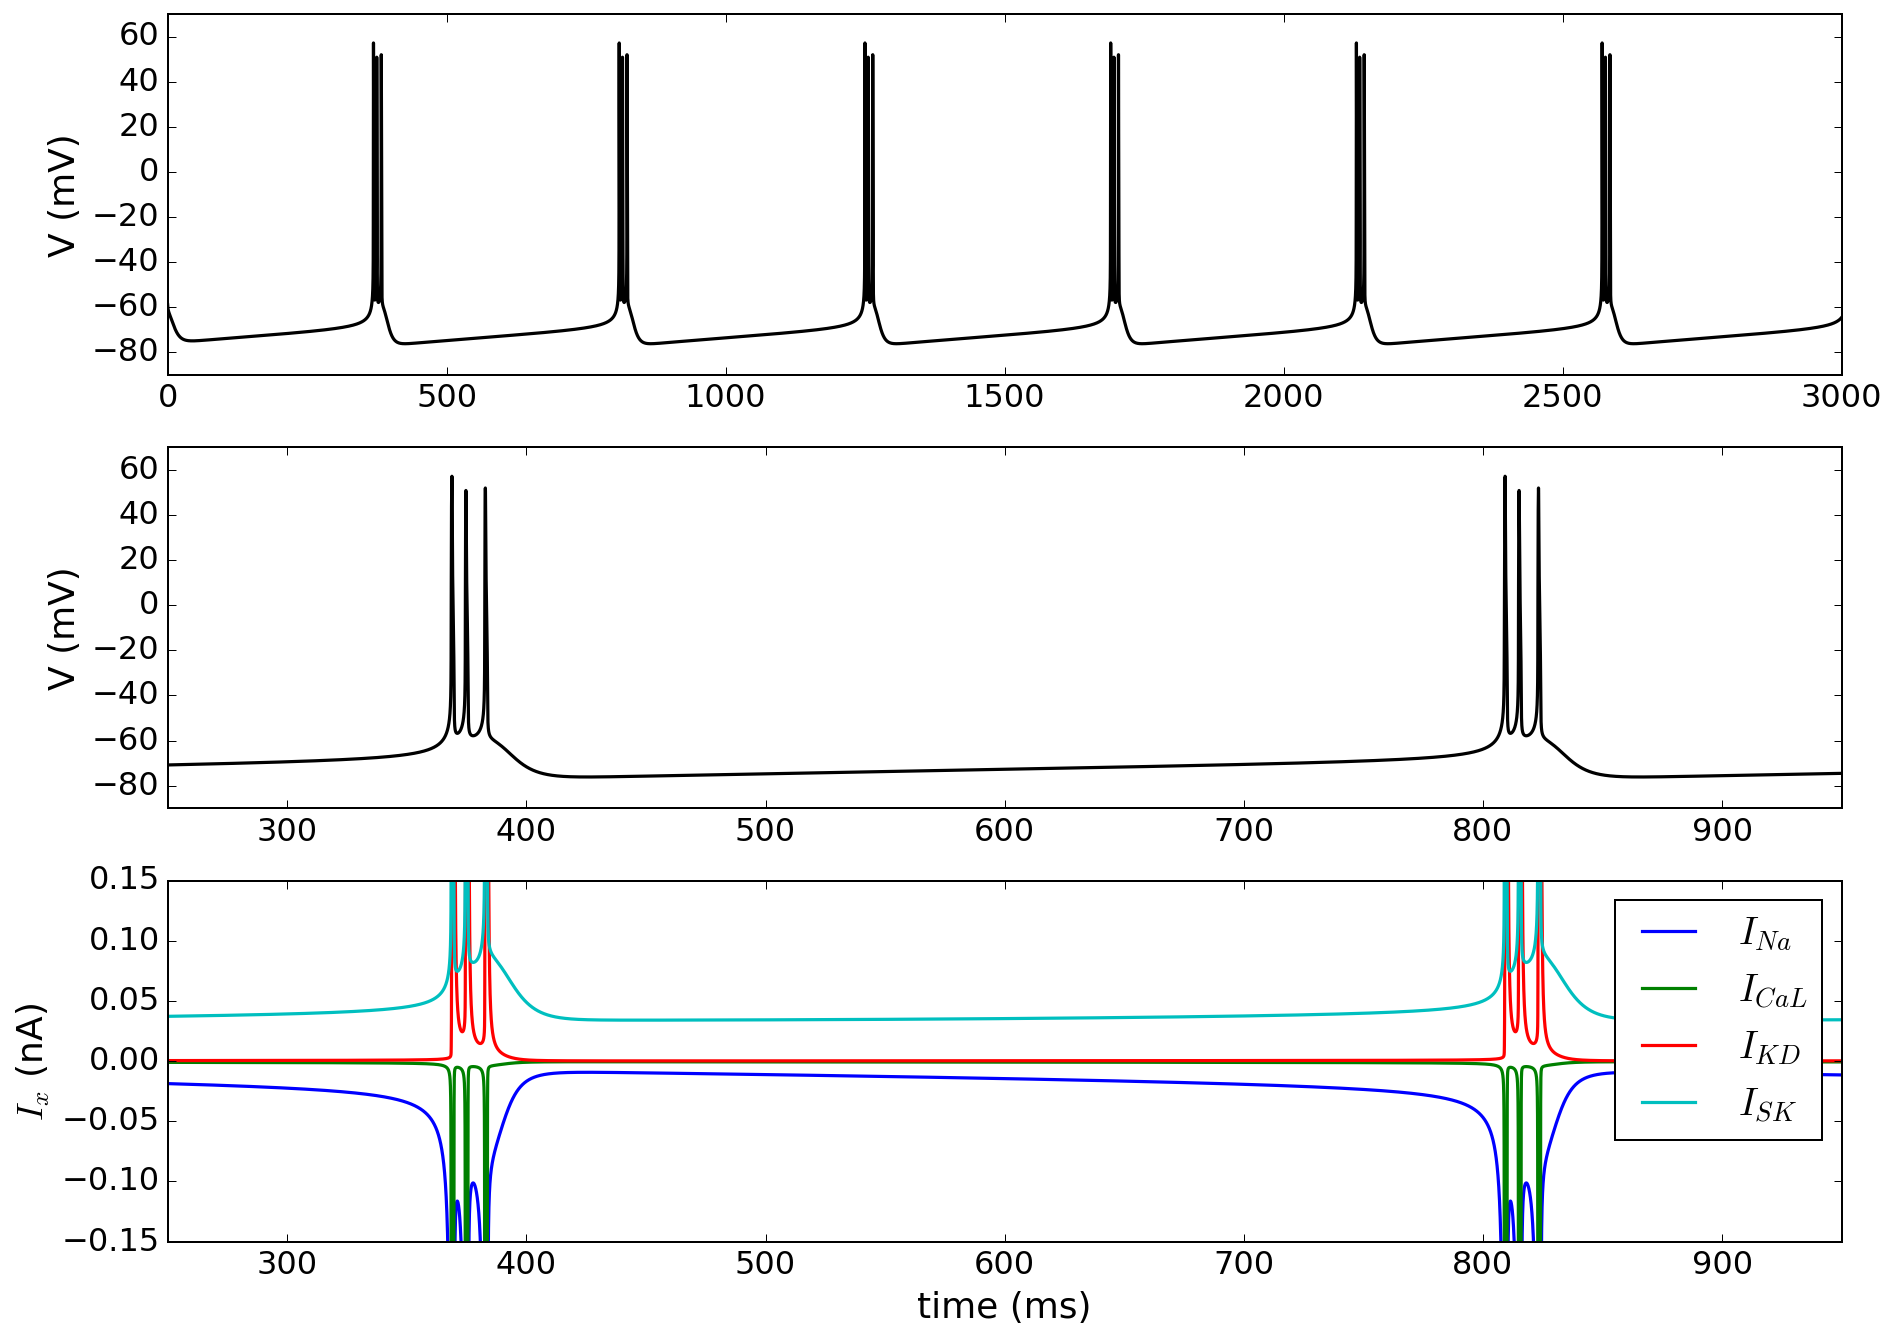

In [30]:
# plot the results of the above simulation
ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.rcParams['lines.linewidth'] = 1.6
plt.ioff()
r=3; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))
    
ax1[0].plot(xx['sampTimes'],xx['v'],'k')
ax1[0].set_ylabel('V (mV)')
ax1[0].set_ylim(-90,70)
ax1[0].set_xlim(0,3000)

ax1[1].plot(xx['sampTimes'],xx['v'],'k')
ax1[1].set_ylabel('V (mV)')
ax1[1].set_ylim(-90,70)
ax1[1].set_xlim(250,950)

ax1[2].plot(xx['sampTimes'],xx['iNaT'],label=r'$I_{Na}$')
ax1[2].plot(xx['sampTimes'],xx['iCa12'],label=r'$I_{CaL}$')
ax1[2].plot(xx['sampTimes'],xx['iKaD'],label=r'$I_{KD}$')
ax1[2].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
ax1[2].set_ylabel('$I_{x}$ (nA)')
ax1[2].set_xlabel('time (ms)')
ax1[2].set_xlim(250,950)
ax1[2].set_ylim(-0.15,0.15)
ax1[2].legend(loc="upper right");

In the top panel, we see that the cell sustains spontaneous bursting for several seconds at a rate of roughly 2 Hz. In the second and third panels, zooming in on the first two bursts in the sequence shows us the shape of the bursts, the number of spikes per bursts and the ion current dynamics. Note that in the third panel, the larger currents are truncated to better visualize the Ca<sup>2+</sup> and Ca<sup>2+</sup>-dependent K<sup>+</sup> currents, especially between bursts. Compare this bursting activity to that from recordings in Golomb et al. (2006).

Next, we compare spontaneous bursting young and aged cells using the different Ca<sup>2+</sup> channel densities, as before.

In [31]:
# run the model for young and aged cells
aCaLs=sc.arange(3e3,7e3,3e3)
ncals=len(aCaLs)

for n in range(ncals):
    p1['a_Ca12']=aCaLs[n]
    p1=calcReversalPotentials(p1)
    p1=normalizeVolts(p1)
    p1=normalizeAmps(p1)
    p1['jStim'] = lambda tt: (UpTopDn(t=tt,upStart=p1['upStart'],upStop=p1['upStop'],
    dnStart=p1['dnStart'],dnStop=p1['dnStop'],rampAmp=p1['rampAmp']))/p1['vTCm']
    p1['verboseSimulation']=0
    xx=simulate3DNeuron(p1,graph=0)
    sims.append(xx)    

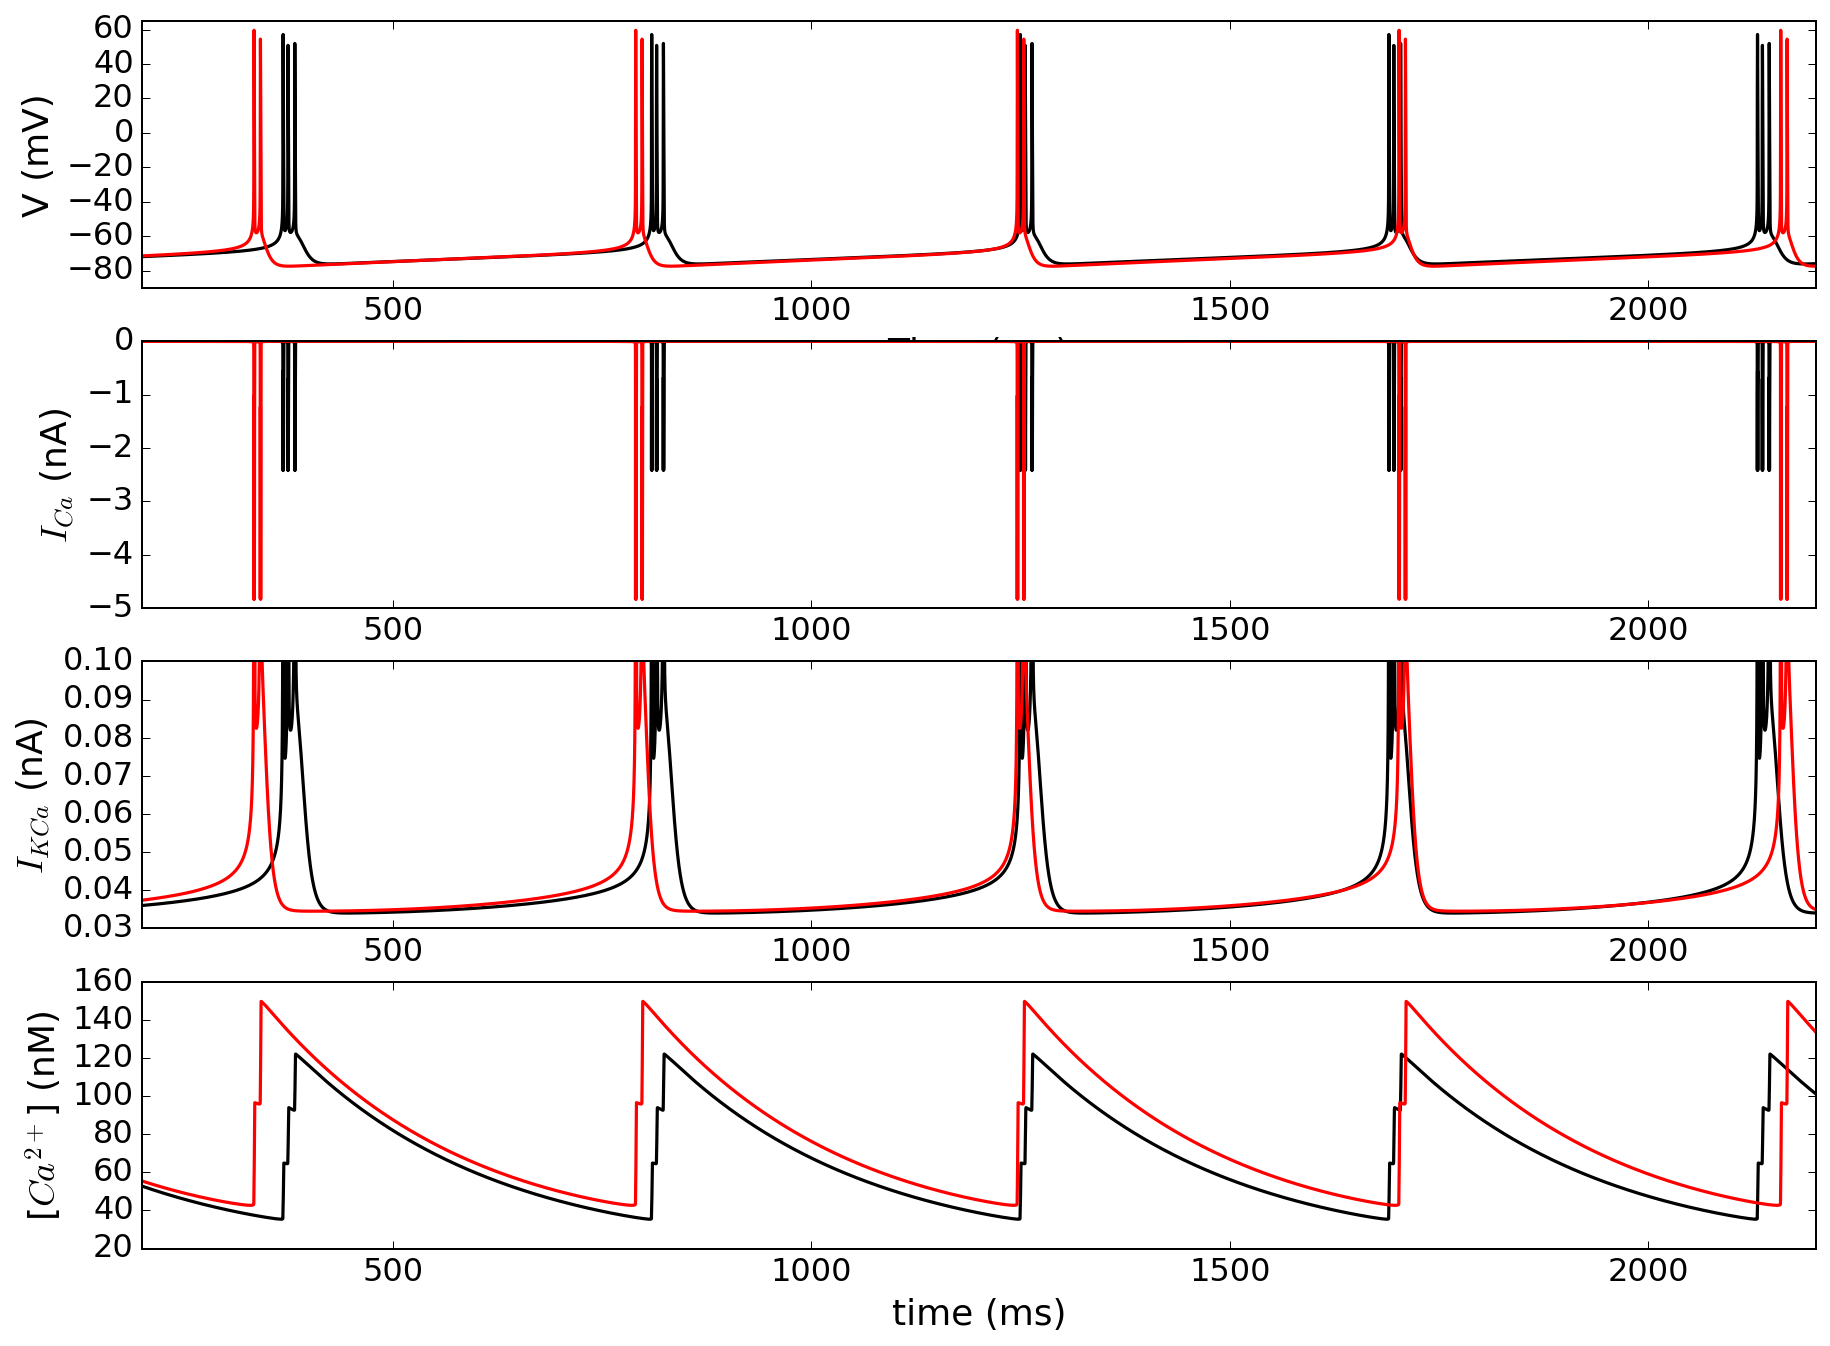

In [35]:
# plot the results from the above simulation
ax1=list()
fig1=plt.figure(figsize=(15,11))
plt.ioff()
r=4; c=1
for s in sc.arange(r*c):
    ax1.append(fig1.add_subplot(r,c,s+1))

ax1[0].set_color_cycle(['black','red'])   
ax1[1].set_color_cycle(['black','red'])
ax1[2].set_color_cycle(['black','red'])   
ax1[3].set_color_cycle(['black','red'])

for n in range(ncals):
    xx=sims[n]
    ax1[0].plot(xx['sampTimes'],xx['v'])
    ax1[0].set_xlabel('Time (ms)')
    ax1[0].set_ylabel('V (mV)')
    ax1[0].set_ylim(-90,65)
    ax1[0].set_xlim(200,2200)
    ax1[1].plot(xx['sampTimes'],xx['iCa12'],label=r'$I_{CaL}$')
    ax1[1].set_ylabel('$I_{Ca}$ (nA)')
    ax1[1].set_xlim(200,2200)
    ax1[2].plot(xx['sampTimes'],xx['iKaSK'],label=r'$I_{SK}$')
    ax1[2].set_ylabel('$I_{KCa}$ (nA)')
    ax1[2].set_xlim(200,2200)
    ax1[2].set_ylim(0.03,0.10)
    scale_y=1e-6
    ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax1[3].yaxis.set_major_formatter(ticks_y)
    ax1[3].plot(xx['sampTimes'],xx['c'])
    ax1[3].set_xlim(200,2200)
    ax1[3].set_xlabel('time (ms)')
    ax1[3].set_ylabel('[$Ca^{2+}$] (nM)');

As in the case of conditional bursting, we can see that the aged PC fires sooner, but with fewer spikes per burst than the young PC. By the third burst, the two cells are firing at roughly the same time. By the fourth burst, the aged cell starts to lag behind the young cell. If we extend the time window further, the aged PC will eventually fire fewer bursts than the young PC in the same time period. As before, these effects are due to increased Ca<sup>2+</sup> entry and the resulting increase in the Ca<sup>2+</sup>-dependent K<sup>+</sup> current in aged cells.

## Local field potential forcing

While square pulse stimulation is useful for examining the timing of neural responses, it is not a physiologically realistic stimulus. Instead, we can define an Ornstein-Uhlenbeck stochastic process to simulate local field potential (LFP) forcing that CA1 PCs could experience due to the electrical activity of cells in their vicinity.

In [36]:
# define OU forcing function
def ouForcing(pa,suffix='_LFP',graph=0):
    """
    Given a dictionary of parameters p1 with data about the OU process, type
    pa1= ouForcing(pa,suffix='_LFP',graph=0)
    """
    if pa['aSD'+suffix]>0:
        diffF=2*pa['aSD'+suffix]/pa['aTau'+suffix]
        ouProcess=sp.OU_process(theta=1/pa['aTau'+suffix], mu=pa['aMean'+suffix], sigma=diffF)
        st= sc.copy(pa['sampTimes'])
        ouPath= ouProcess.sample_path(st)[0]
        ouFunc=lambda t: sc.interp(t,st, ouPath)
        pa['aOU'+suffix]=ouProcess
        pa['aOUFunc'+suffix]=ouFunc
        pa['aOUPath'+suffix]=ouPath
        if graph:
            plt.figure()
            plt.plot(st, ouPath, label=r'$a_{%s}$'%suffix)
            plt.legend()
    else:
        print('Could not simulate OU process')
    return pa

Now, we redefine the right-hand side to include the LFP forcing.

In [37]:
# define right-hand side to include LFP (OU) forcing
def NaTKDSKCaLOU(U,t,p):
    y,w,c=U
    p['vCa']=vNernst(cIn=c, cOut=p['outCa'], val=2.0, tempCelsius=p['tempCelsius'])
    p['vCaovervT']=p['vCa']/p['vT']
    # ion channel gating
    yyKaD = p['gainP_KaD']*(y-p['vHalfP_KaDovervT'])
    wInf = nExpSigmoid(yyKaD)
    wRate = p['rateP_KaD'] * nExpSum(yyKaD,s=p['symmP_KaD'])
    m12Inf = nExpSigmoid(p['gainP_Ca12']*(y-p['vHalfP_Ca12overvT']))
    m13Inf = nExpSigmoid(p['gainP_Ca13']*(y-p['vHalfP_Ca13overvT']))
    mInf = nExpSigmoid(p['gainP_NaT']*(y-p['vHalfP_NaTovervT']))
    cDiff=p['gainP_KaSK']*(c-p['cHalfP_KaSK'])
    skInf=  nExpSigmoid(cDiff)
    # ion currents
    jNa = p['a_NaTovervTCm'] * mInf * (1-w) * nExpSub(y- p['vNaovervT'], s=p['symm_NaT'])
    aCaL =p['a_Ca12overvTCm'] * m12Inf + p['a_Ca13overvTCm'] * m13Inf 
    jCaL = aCaL * (c**(1-p['symm_Ca13'])) * nExpSub(2*(y- p['vCaovervT']), s=p['symm_Ca13'])
    aK = (p['a_KaSKovervTCm'] * skInf + p['a_KaDovervTCm'] * w )
    jK = aK * nExpSub(y- p['vKaovervT'], s=p['symm_KaD'])
    jNaKa = p['a_NaKaovervTCm'] * nExpSub(y- p['vNaKaovervT'], s=p['symm_NaKa'])
    jLFP = p['aOUFunc_LFP'](t)/p['vTCm']
    # model dynamics
    dy = p['jStim'](t) - jNa - jK - jNaKa - jCaL -jLFP
    dw = w * (wInf-w)* wRate
    dc= p['rc_Ca'] * (p['cMin_Ca']-c) - p['kc_Ca']* (jCaL)*p['vTCm']
    if p['verboseSimulation'] & (t%p['verboseSimulation'] <0.01):
        print(t,c, p['a_NaT'], p['a_KaD'], aCaL, p['vCa'])
    return dy,dw,dc

Now, let's run the model with the LFP forcing and plot the results. As before, we alter the Ca<sup>2+</sup> channel densities to represent young and old cells.

In [39]:
# run model with OU forcing (Note: Simulation can take some time (around 10 mins). Be patient, it's worth it!)
p1['a_NaT']=3e3
p1['a_KaD']=2.5e4
p1['a_KaSK']=1e3
p1['a_NaKa']=0.01*p1['a_NaT']
p1['a_Ca12']=3e3
p1['rateP_KaD']=2.5
p1['rampAmp']=35.0
p1['kc_Ca']=2e-8
p1['rc_Ca']=4e-3
p1['aMean_LFP']=-40.0
p1['aSD_LFP']=20.0
p1=ouForcing(p1,suffix='_LFP',graph=0)
p1['jStim'] = lambda t: 0
p1['sampTimes']=sc.arange(0,p1['timeMax'],p1['timeStep'])
p1['rhs']= NaTKDSKCaLOU
p1['verboseSimulation']=200
sims= list()
    
for n in range(ncals):
    p1['a_Ca12']=aCaLs[n]
    p1=calcReversalPotentials(p1)
    p1=normalizeVolts(p1)
    p1=normalizeAmps(p1)
    xx=simulate3DNeuron(p1, graph=0)
    sims.append(xx)

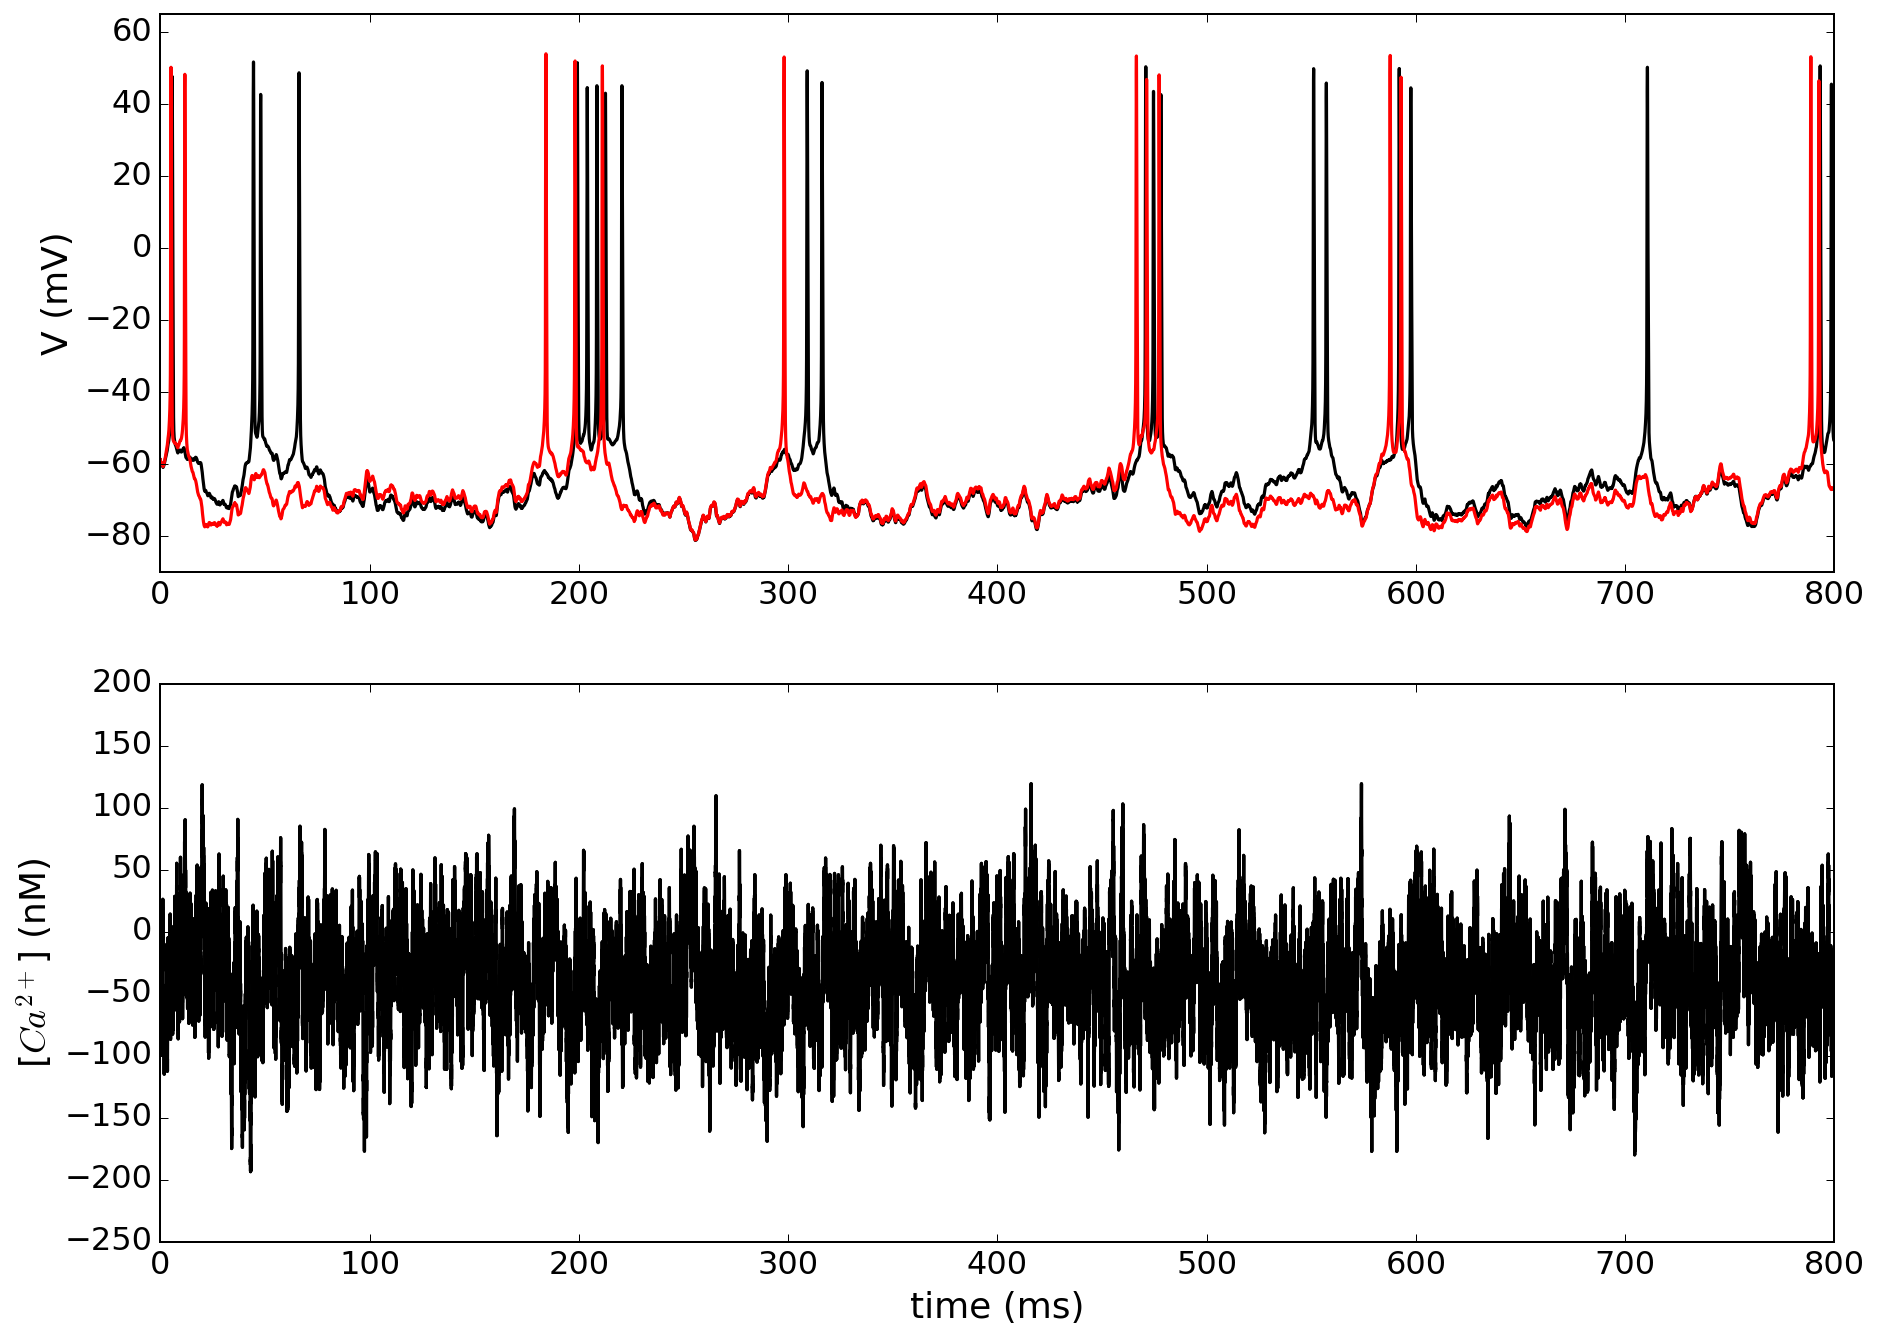

In [40]:
# plot results of simulation with OU forcing 
ax2=list()
fig2=plt.figure(figsize=(15,11))
plt.ioff()
r=2; c=1
for s in sc.arange(r*c):
    ax2.append(fig2.add_subplot(r,c,s+1))

ax2[0].set_color_cycle(['black','red'])   
ax2[1].set_color_cycle(['black','red'])
plotLFP=1; plotStim=0
for n in range(ncals):
    xx=sims[n]
    ax2[0].plot(xx['sampTimes'],xx['v'])
    ax2[0].set_ylabel('V (mV)')
    ax2[0].set_ylim(-90,65)
    ax2[0].set_xlim(0,800)
    ax2[1].plot(xx['sampTimes'], p1['aOUFunc_LFP'](p1['sampTimes']),'k')
    ax2[1].set_xlim(0,800)
    ax2[1].set_xlabel('time (ms)')
    ax2[1].set_ylabel('[$Ca^{2+}$] (nM)')
        
plt.ion(); plt.draw()
plt.show()

Next steps are to work on modeling synaptic input, and different balances of excitation and inhibition.